# Data Exploration

In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [2]:
def json_to_df(json_file=None):
    """ Reads a single JSON file containing the
    shipment information and converts it to a
    structured dataframe
    """
    import pandas as pd
    from pandas.io.json import json_normalize
    import numpy as np
    logger.debug("Converting to dataframe: {}".format(json_file))
    df = pd.read_json(json_file, dtype={"shipment_number": str})
    normalized_df = json_normalize(df['events'])
    df.drop(["events"], axis=1, inplace=True)
    df = pd.concat([df, normalized_df], axis=1)
    if "Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen." == df.tail(1)["status"].item():
        logger.warning("Final delivery state is strange! Ignoring the file {}".format(json_file))
        return
    # Some files have multiple states. It does not make sense!
    if df[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].shape[0] > 1:
        logger.warning("Multiple final states! Ignoring the file {}".format(json_file))
        return
    if df["status"].isnull().any():
        logger.warning("Status column has missing values! Ignoring the file {}".format(json_file))
        return
    if len(df["url"].unique()) > 1:
        logger.warning("Multiple URLs for a single shipment number! Something is wrong")
    if len(df["shipment_number"].unique()) > 1:
        logger.warning("Multiple shipment numbers in the same file. Something is wrong")
    df['crawltime'] = pd.to_datetime(df['crawltime'], utc=True)
    df['datum'] = pd.to_datetime(df['datum'], utc=True)
    if df["status"].isnull().values.any():
        logger.warning("Column status has missing values! ShipmentNumber: {}".format(df["shipment_number"].values[0]))
    final_event_array = np.zeros(len(df))
    final_event_array[-1] = 1
    df["is_final_event"] = final_event_array
    return df

In [3]:
def files_to_df(path='../data'):
    """ Convert all files to a single dataframe
    """
    import os
    import pandas as pd
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    dfs = [json_to_df(json_file=file) for file in files]
    df = pd.concat(dfs, sort=False)
    return df

In [4]:
df = files_to_df(path='../data')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### Are there any missing values?

In [5]:
import pandas as pd
def count_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df
missing_value_df = count_missing_values(df)

In [6]:
missing_value_df

column_name  percent_missing
shipment_number  shipment_number         0.000000
crawltime              crawltime         0.000000
url                          url         0.000000
datum                      datum         0.000000
status                    status         0.000000
ort                          ort        59.510169
is_final_event    is_final_event         0.000000

Column "ort" has many missing values. We fill them with "Unbekannt"

In [7]:
def fill_missing_values(df):
    """ Fills missing values of specific columns
    in the data frame with pre-defined values.
    """
    df['ort'].fillna("Unbekannt", inplace=True)
    logger.debug("Filled missing values for ort column")
    return df

In [8]:
df = fill_missing_values(df)

Check again if there are any missing values

In [9]:
count_missing_values(df)

column_name  percent_missing
shipment_number  shipment_number              0.0
crawltime              crawltime              0.0
url                          url              0.0
datum                      datum              0.0
status                    status              0.0
ort                          ort              0.0
is_final_event    is_final_event              0.0

### Data Stats

In [10]:
df.shape

(6982, 7)

Number of unique shipment numbers

In [11]:
len(df.shipment_number.unique())

1277

### Investigate Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6982 entries, 0 to 5
Data columns (total 7 columns):
shipment_number    6982 non-null object
crawltime          6982 non-null datetime64[ns, UTC]
url                6982 non-null object
datum              6982 non-null datetime64[ns, UTC]
status             6982 non-null object
ort                6982 non-null object
is_final_event     6982 non-null float64
dtypes: datetime64[ns, UTC](2), float64(1), object(4)
memory usage: 436.4+ KB


Everything regarding data types seems to be fine! No need for conversion

### Prepare data for exploration and machine learning

- Given the features "datum", "status" and "ort" we want to predict the next "datum" and hopefully also the next "status" and the next "ort"
- We create 3 new columns. "datum_next", "ort_next" and "status_next".

In [13]:
def create_target_columns(df):
    import numpy as np 

    df['status_next'] = df.groupby(['shipment_number'])['status'].shift(-1)
    df['ort_next'] = df.groupby(['shipment_number'])['ort'].shift(-1)
    df['datum_next'] = df.groupby(['shipment_number'])['datum'].shift(-1)
    # we define values for the case the package is already delivered.
    df.loc[df['is_final_event'] == 1, 'status_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'ort_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'datum_next'] = np.datetime64('today')
    
    return df

In [14]:
# Disable warnings
pd.set_option('mode.chained_assignment', None)
df = create_target_columns(df)

In [15]:
df.head()

shipment_number                 crawltime  \
0  00340434188193339722 2019-12-12 13:24:20+00:00   
1  00340434188193339722 2019-12-12 13:24:20+00:00   
2  00340434188193339722 2019-12-12 13:24:20+00:00   
3  00340434188193339722 2019-12-12 13:24:20+00:00   
4  00340434188193339722 2019-12-12 13:24:20+00:00   

                                                 url  \
0  https://www.dhl.de/int-verfolgen/search?langua...   
1  https://www.dhl.de/int-verfolgen/search?langua...   
2  https://www.dhl.de/int-verfolgen/search?langua...   
3  https://www.dhl.de/int-verfolgen/search?langua...   
4  https://www.dhl.de/int-verfolgen/search?langua...   

                      datum  \
0 2019-11-29 15:27:00+00:00   
1 2019-11-30 14:04:00+00:00   
2 2019-12-02 21:11:00+00:00   
3 2019-12-03 08:33:00+00:00   
4 2019-12-03 11:28:00+00:00   

                                              status           ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...     Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...       Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...  Gu00FCnzburg   
3  Die Sendung wurde in das Zustellfahrzeug gelad...     Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.     Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next          datum_next  
0          Hamburg 2019-11-30 14:04:00  
1     Gu00FCnzburg 2019-12-02 21:11:00  
2        Unbekannt 2019-12-03 08:33:00  
3        Unbekannt 2019-12-03 11:28:00  
4  SuccessDelivery 2019-12-12 00:00:00

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6982 entries, 0 to 5
Data columns (total 10 columns):
shipment_number    6982 non-null object
crawltime          6982 non-null datetime64[ns, UTC]
url                6982 non-null object
datum              6982 non-null datetime64[ns, UTC]
status             6982 non-null object
ort                6982 non-null object
is_final_event     6982 non-null float64
status_next        6982 non-null object
ort_next           6982 non-null object
datum_next         6982 non-null datetime64[ns]
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(1), object(6)
memory usage: 600.0+ KB


### Data Stats

In [17]:
count_missing_values(df)

column_name  percent_missing
shipment_number  shipment_number              0.0
crawltime              crawltime              0.0
url                          url              0.0
datum                      datum              0.0
status                    status              0.0
ort                          ort              0.0
is_final_event    is_final_event              0.0
status_next          status_next              0.0
ort_next                ort_next              0.0
datum_next            datum_next              0.0

In [18]:
df.shape

(6982, 10)

Number of unique shipment numbers

In [19]:
len(df.shipment_number.unique())

1277

In [20]:
len(df.status.unique())

191

In [21]:
len(df.ort.unique())

141

### How many different final delivery states exist?

In [22]:
final_delivery_states = df.groupby(['shipment_number']).tail(1)[["status"]]["status"].unique()
print(final_delivery_states)

['Die Sendung wurde erfolgreich zugestellt.'
 'Der Empfu00E4nger hat die Sendung in der Filiale abgeholt.'
 "Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address= ' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale &lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden."
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Der Empfu00E4nger hat die Sendung aus der PACKSTATION abgeholt.'
 'Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.'
 'Die Sendung wurde leider fehlgeleitet. Gegebenenfalls verzu00F6gert sich dadurch die Zustellung.'
 "Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Oberhausen Weierstr. 195' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Fi

### How many different initial delivery states exist?

In [23]:
initial_delivery_states = df.groupby(['shipment_number']).head(1)[["status"]]["status"].unique()
print(initial_delivery_states)

['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.']


### Distribution of final delivery states

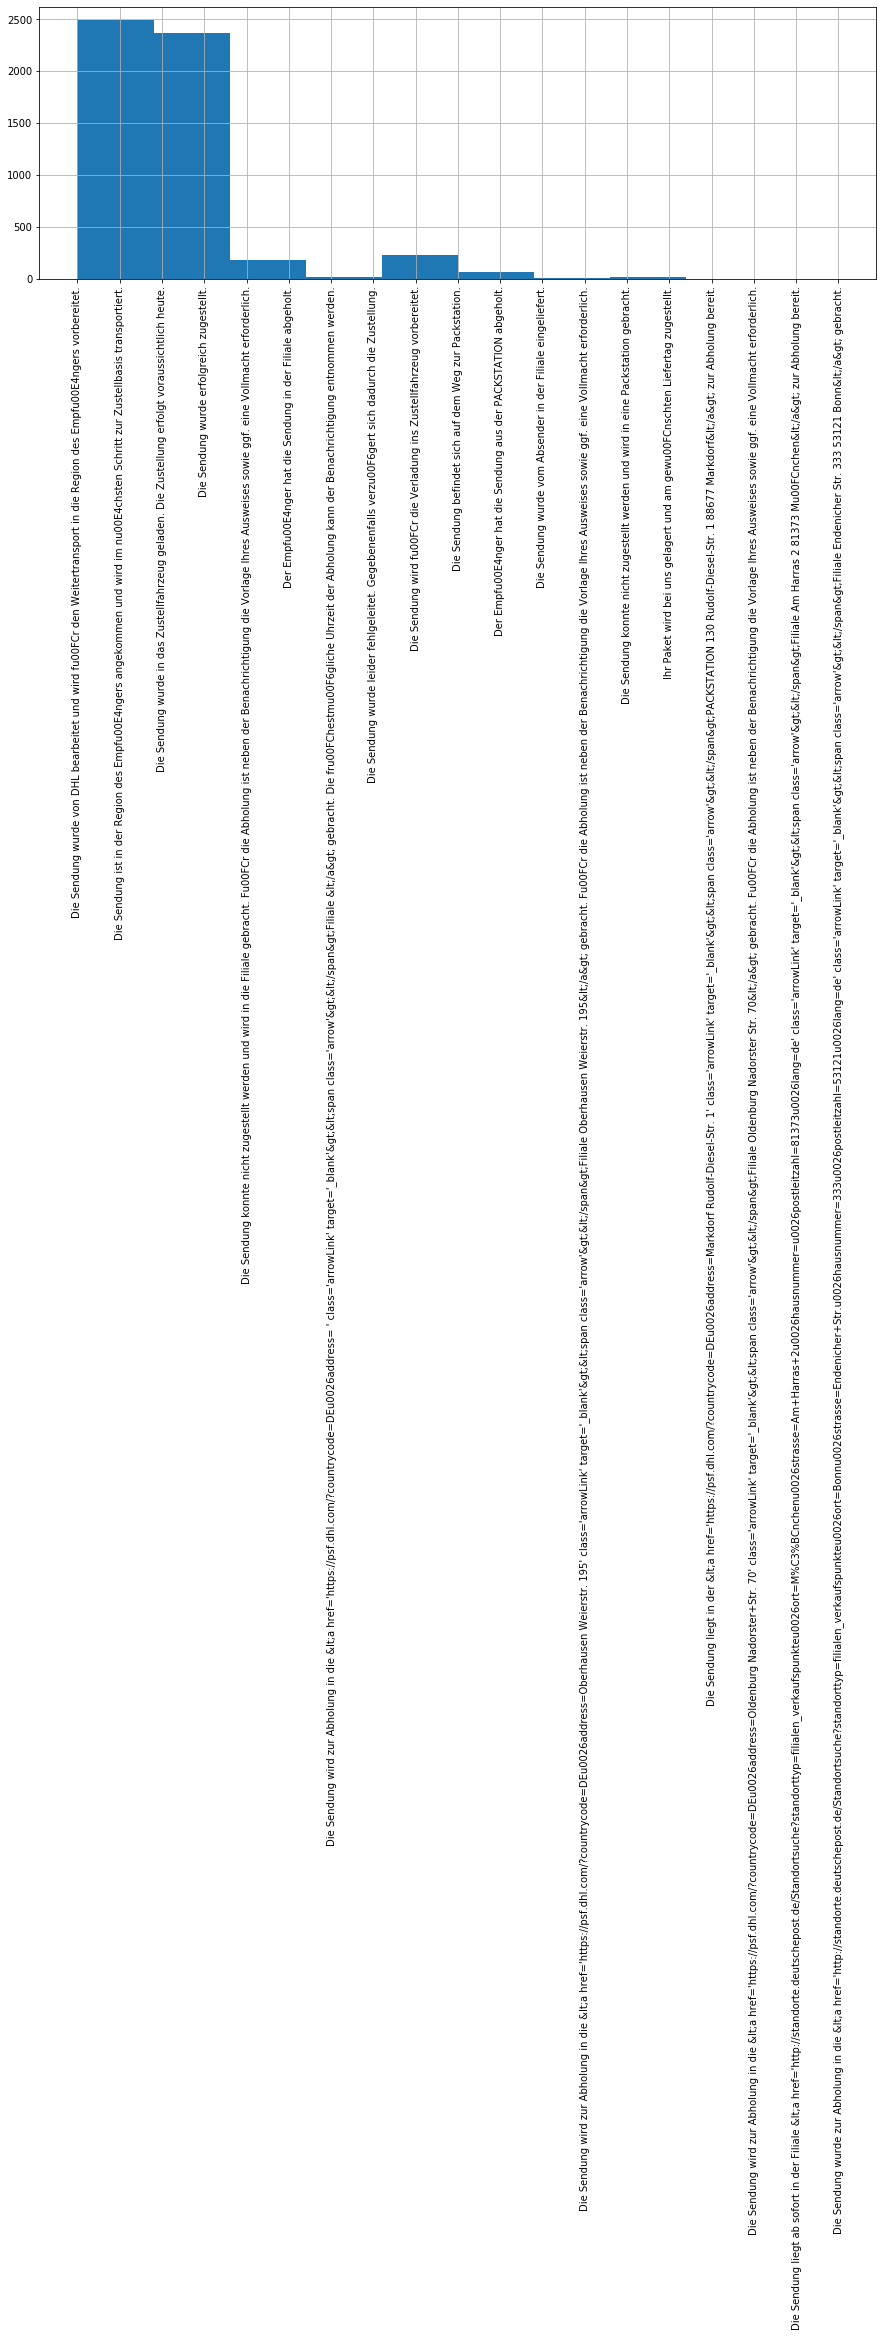

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(final_delivery_states)]["status"].hist(figsize=(15,5))

### Distribution of initial states

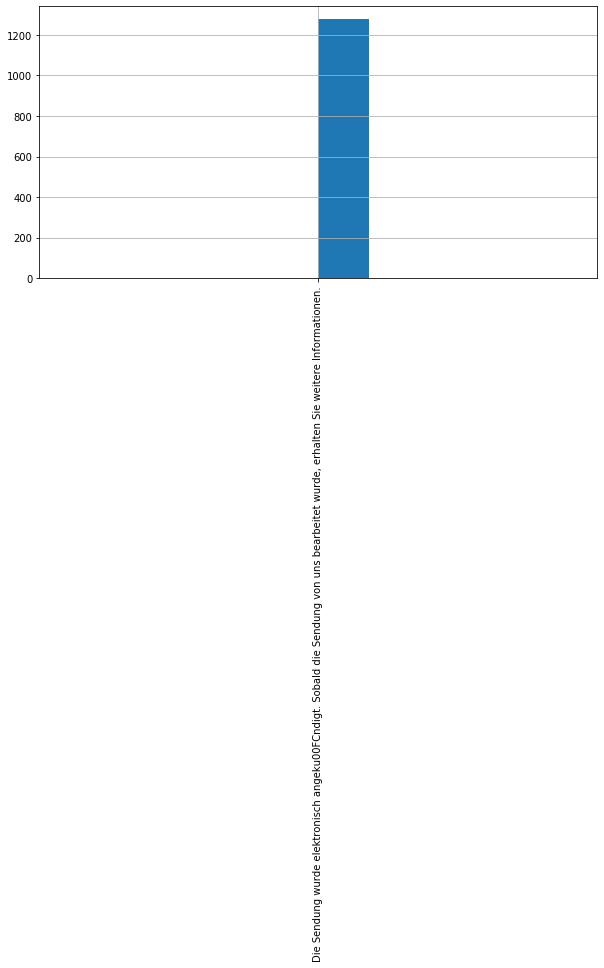

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(initial_delivery_states)]["status"].hist(figsize=(10,5))

### Distribution of all states

These are the most common states

In [26]:
pd.DataFrame(df["status"].value_counts()).head(10)

status
Die Sendung wurde in das Zustellfahrzeug gelade...    1279
Die Sendung wurde elektronisch angeku00FCndigt....    1277
Die Sendung wurde von DHL bearbeitet und wird f...    1264
Die Sendung ist in der Region des Empfu00E4nger...    1230
Die Sendung wurde erfolgreich zugestellt.             1092
Die Sendung wird fu00FCr die Verladung ins Zust...     228
Der Empfu00E4nger hat die Sendung in der Filial...      95
Die Sendung konnte nicht zugestellt werden und ...      89
Die Sendung wird fu00FCr den Weitertransport vo...      57
Die Zustellung an einen gewu00FCnschten Ablageo...      43

These are the least common states. What we see here is that there are some states that are basically the same and the following pattern:

"Die Sendung liegt in der ........ zur Abholung bereit"

But the address is each time different. This leads to too many states, which also makes machine learning hard. We ignore the address part and convert all these states to a single one.

In [27]:
pd.DataFrame(df["status"].value_counts()).tail(10)

status
Die Sendung liegt in der &lt;a href='https://ps...       1
Die Sendung liegt in der &lt;a href='https://ps...       1
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Sendung liegt in der &lt;a href='https://ps...       1
Die geringfu00FCgig beschu00E4digte Sendung wur...       1
Die Sendung liegt ab sofort in der Filiale &lt;...       1
Die Sendung liegt ab sofort in der Filiale &lt;...       1
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Zustellung am gewu00FCnschten Liefertag 04....       1
Die Sendung liegt ab sofort in der Filiale &lt;...       1

In [28]:
df.loc[(df['status'].str.startswith("Die Sendung liegt in der")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status'].str.endswith("gebracht.")), "status"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status'].str.endswith("wurde gewu00E4hlt.")), "status"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden." 


df.loc[(df['status_next'].str.startswith("Die Sendung liegt in der")) & (df['status_next'].str.endswith("zur Abholung bereit.")), "status_next"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status_next'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status_next'].str.endswith("gebracht.")), "status_next"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status_next'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status_next'].str.endswith("wurde gewu00E4hlt.")), "status_next"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden." 

In [29]:
pd.DataFrame(df["status"].value_counts()).head(10)

status
Die Sendung wurde in das Zustellfahrzeug gelade...    1279
Die Sendung wurde elektronisch angeku00FCndigt....    1277
Die Sendung wurde von DHL bearbeitet und wird f...    1264
Die Sendung ist in der Region des Empfu00E4nger...    1230
Die Sendung wurde erfolgreich zugestellt.             1092
Die Sendung wird fu00FCr die Verladung ins Zust...     228
Der Empfu00E4nger hat die Sendung in der Filial...      95
Die Sendung konnte nicht zugestellt werden und ...      89
Die Sendung wird fu00FCr den Weitertransport vo...      57
Die Sendung wird zur Abholung in die ... gebrac...      49

In [30]:
pd.DataFrame(df["status"].value_counts()).tail(10)

status
Ihr Paket wird bei uns gelagert und am gewu00FC...       3
Die Sendung befindet sich in der Zustellbasis u...       2
Die Sendung wurde vom Absender in der Filiale e...       2
Leider ist eine Zustellung der Sendung nicht mu...       2
Leider war eine Zustellung Ihrer Sendung heute ...       2
Die Sendung konnte beim 2. Zustellversuch nicht...       1
Die Sendung in Paketkasten-Anlage eingestellt            1
Die Sendung wurde zum Weitertransport aus der P...       1
Der gewu00FCnschte Liefertag wurde storniert od...       1
Die geringfu00FCgig beschu00E4digte Sendung wur...       1

In [31]:
len(df["status"].unique())

39

In [32]:
len(df["status_next"].unique())

60

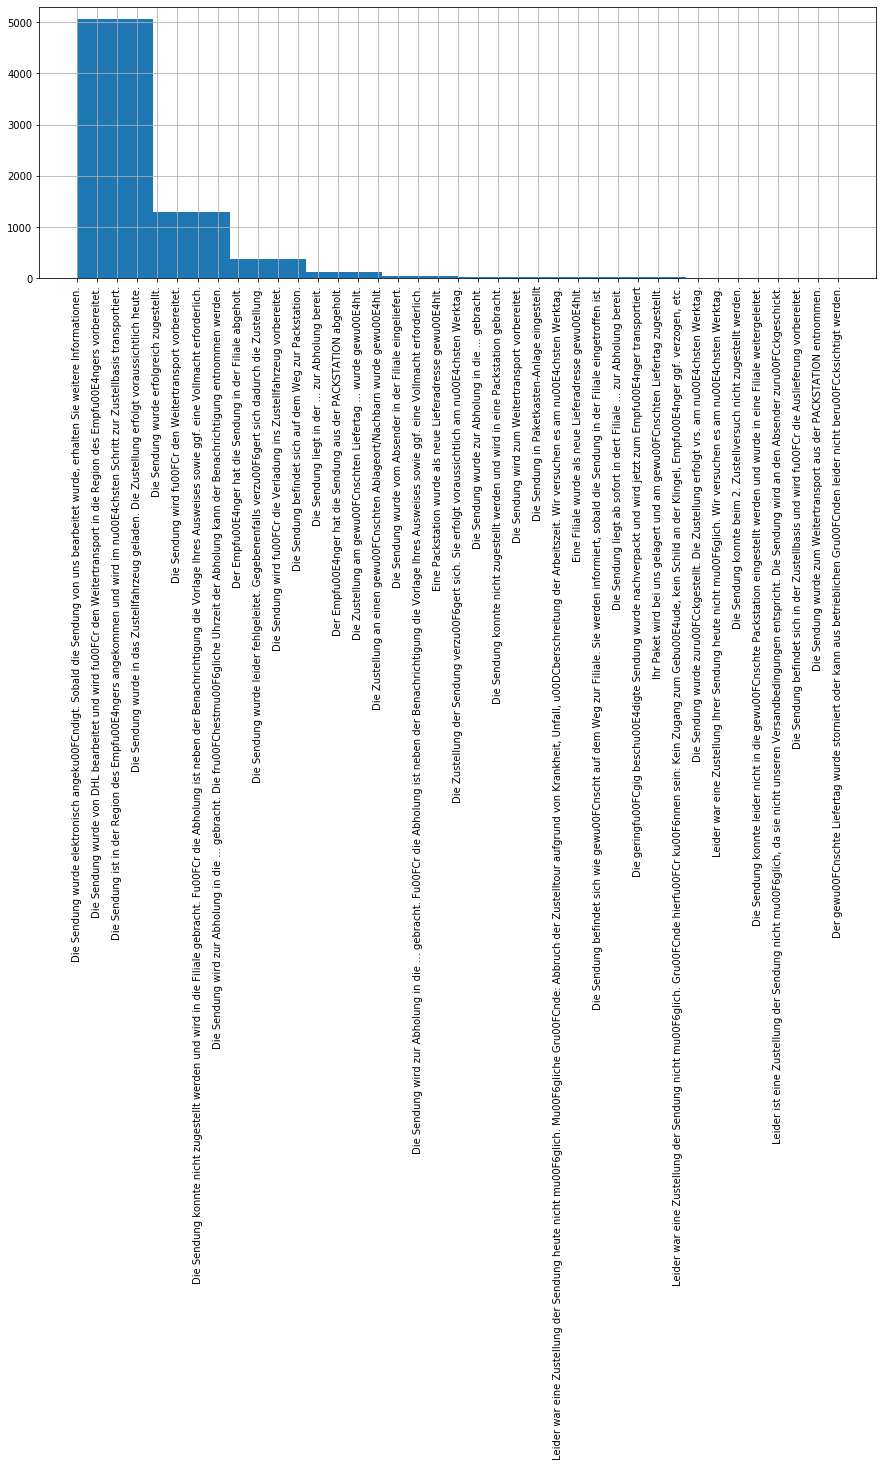

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
df["status"].hist(figsize=(15,5))

We introduces two new states to status_next: SuccessDelivery, FailedDelivery

### Distribution of the locations

In [34]:
len(df["ort"].unique())

141

In [35]:
pd.DataFrame(df["ort"].value_counts()).head(20)

ort
Unbekannt            4155
Hamburg              1266
Neumu00FCnster         80
Ku00F6ln               67
Hagen                  59
Ku00F6ngen             57
Krefeld                56
Feucht                 52
Bielefeld              48
Hannover               48
Bremen GVZ             47
Regensburg             46
Obertshausen           46
Gu00FCnzburg           43
Augsburg               39
Dorsten                37
Eutingen im Gu00E4u    35
Kitzingen              32
Bruchsal               32
Staufenberg            31

In [36]:
pd.DataFrame(df["ort"].value_counts()).tail(20)

ort
Berlin                           1
Rostock                          1
Hu00FCrth                        1
Wilhelmshaven                    1
Efringen-Kirchen MechZB          1
Moers MechZB                     1
Holzgerlingen MechZB             1
Schmelz                          1
Osterholz MechZB                 1
Oranienburg                      1
Tornesch MechZB                  1
Heidenheim an der Brenz          1
Hanau MechZB                     1
Nienburg                         1
Bad Kreuznach                    1
Eckental                         1
Du00FCsseldorf-Su00FCd MechZB    1
Kaarst                           1
Heidelberg                       1
Elmshorn                         1

Notice: One idea here could be to merge some locations. 

### Remove unused columns

In [37]:
df.drop(columns=["crawltime", "url"], inplace=True)

In [38]:
df.head()

shipment_number                     datum  \
0  00340434188193339722 2019-11-29 15:27:00+00:00   
1  00340434188193339722 2019-11-30 14:04:00+00:00   
2  00340434188193339722 2019-12-02 21:11:00+00:00   
3  00340434188193339722 2019-12-03 08:33:00+00:00   
4  00340434188193339722 2019-12-03 11:28:00+00:00   

                                              status           ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...     Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...       Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...  Gu00FCnzburg   
3  Die Sendung wurde in das Zustellfahrzeug gelad...     Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.     Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next          datum_next  
0          Hamburg 2019-11-30 14:04:00  
1     Gu00FCnzburg 2019-12-02 21:11:00  
2        Unbekannt 2019-12-03 08:33:00  
3        Unbekannt 2019-12-03 11:28:00  
4  SuccessDelivery 2019-12-12 00:00:00

### Distribution of event times

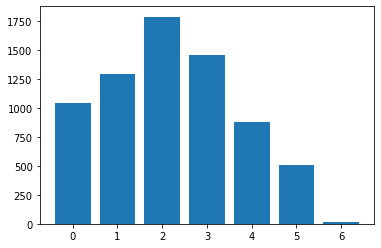

In [39]:
counts = df['datum'].dt.dayofweek.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

We see in the above plot which days of the week have the highest amount of events. Sunday has for example the least amount of events, as expected.

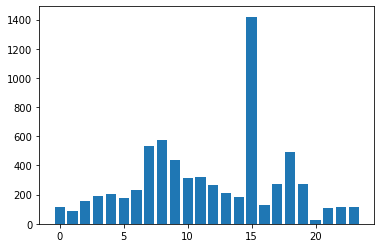

In [40]:
counts = df['datum'].dt.hour.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

In the above plot we see the distribution of the events over 24 hours of a day

### Time diff between events

In [41]:
df['datum'] = pd.to_datetime(df['datum'], utc=True)
df['datum_next'] = pd.to_datetime(df['datum_next'], utc=True)
df["datum_diff"] = df["datum_next"] - df["datum"]

Notice that for is_final_event=1, the datum_diff does not make any sense. Do not use it in the analysis

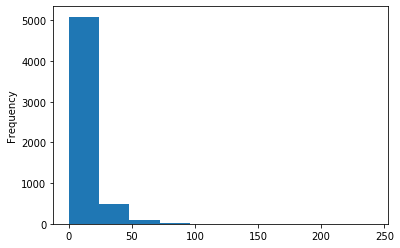

In [42]:
df[df["is_final_event"] == 0]['datum_diff'].astype('timedelta64[h]').plot.hist()

We observe two interesting things here. There are events with zero time diff and there are events with very big time diffs.

### Events with very small time diffs

In [43]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[s]') == 0)] 

shipment_number                     datum  \
3  00340434188193344603 2019-12-07 09:40:00+00:00   
5  00340434188193344603 2019-12-09 06:55:00+00:00   
1  00340434188193341114 2019-12-02 19:06:00+00:00   
3  00340434188193334130 2019-11-26 11:16:00+00:00   
3  00340434188193342098 2019-12-05 11:37:00+00:00   
5  00340434188193334598 2019-11-27 11:50:00+00:00   
3  00340434188193334062 2019-11-26 08:27:00+00:00   
5  00340434188193338169 2019-11-28 08:57:00+00:00   
3  00340434188193336462 2019-11-26 08:25:00+00:00   
4  00340434188193335540 2019-11-28 06:13:00+00:00   
3  00340434188193333744 2019-11-23 06:33:00+00:00   
3  00340434188193345228 2019-12-11 08:28:00+00:00   
2  00340434188193345044 2019-12-05 06:23:00+00:00   
4  00340434188193336127 2019-11-26 07:37:00+00:00   
3  00340434188193334321 2019-11-26 06:37:00+00:00   
3  00340434188193335434 2019-11-27 08:16:00+00:00   
3  00340434188193341831 2019-12-05 09:46:00+00:00   
4  00340434188193335496 2019-11-27 09:02:00+00:00   
6  00340434188193342968 2019-12-07 13:41:00+00:00   
3  00340434188193343682 2019-12-05 08:43:00+00:00   
3  00340434188193342197 2019-12-05 08:42:00+00:00   
4  00340434188193335854 2019-11-26 08:14:00+00:00   
5  00340434188193335090 2019-11-27 08:21:00+00:00   
4  00340434188193343118 2019-12-06 08:04:00+00:00   
3  00340434188193336370 2019-11-26 07:05:00+00:00   
3  00340434188193340759 2019-12-04 08:55:00+00:00   
3  00340434188193343163 2019-12-06 14:35:00+00:00   
2  00340434188193343224 2019-12-05 09:51:00+00:00   
5  00340434188193338091 2019-11-28 09:05:00+00:00   
3  00340434188193335441 2019-11-26 07:34:00+00:00   
6  00340434188193335441 2019-11-26 13:51:00+00:00   
4  00340434188193336257 2019-11-26 10:15:00+00:00   
4  00340434188193340193 2019-12-03 07:29:00+00:00   
3  00340434188193345693 2019-12-12 12:08:00+00:00   
4  00340434188193341428 2019-12-06 09:18:00+00:00   
3  00340434188193336684 2019-11-26 08:05:00+00:00   
4  00340434188193337735 2019-11-29 06:23:00+00:00   
3  00340434188193344535 2019-12-09 09:51:00+00:00   
4  00340434188193345488 2019-12-12 08:16:00+00:00   
2  00340434188193335847 2019-11-26 07:28:00+00:00   
4  00340434188193345211 2019-12-06 07:54:00+00:00   
4  00340434188193346041 2019-12-12 07:50:00+00:00   
4  00340434188193344436 2019-12-05 09:42:00+00:00   
3  00340434188193339081 2019-11-29 08:01:00+00:00   
3  00340434188193341176 2019-12-04 11:17:00+00:00   
7  00340434188193342081 2019-12-11 12:34:00+00:00   
5  00340434188193334345 2019-11-26 08:02:00+00:00   

                                              status        ort  \
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
5  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
5  Die Sendung liegt in der ... zur Abholung bereit.     Berlin   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
5  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
2  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
6  Die Sendung konnte nicht zugestellt werden und...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Un

### Events with huge time diffs

In [44]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[h]') > 150)] 

shipment_number                     datum  \
5  00340434188193339036 2019-11-30 14:46:00+00:00   
5  00340434188193337681 2019-11-27 12:07:00+00:00   
7  00340434188193337254 2019-11-28 00:05:00+00:00   
6  00340434188193335045 2019-11-28 07:53:00+00:00   
5  00340434188193337384 2019-11-27 16:32:00+00:00   
6  00340434188193336608 2019-11-26 16:24:00+00:00   
6  00340434188193337667 2019-11-29 07:29:00+00:00   
7  00340434188193334666 2019-12-02 10:19:00+00:00   

                                              status                 ort  \
5          Die Sendung wurde erfolgreich zugestellt.           Unbekannt   
5          Die Sendung wurde erfolgreich zugestellt.           Unbekannt   
7  Die Sendung wird fu00FCr die Verladung ins Zus...  Hattersheim MechZB   
6  Die Sendung liegt ab sofort in dert Filiale .....           Unbekannt   
5  Die Sendung liegt ab sofort in dert Filiale .....           Unbekannt   
6  Die Sendung liegt ab sofort in dert Filiale .....           Unbekannt   
6  Die Sendung liegt ab sofort in dert Filiale .....           Unbekannt   
7  Die Sendung wird zur Abholung in die ... gebra...           Unbekannt   

   is_final_event                                        status_next  \
5             0.0  Die Sendung wurde vom Absender in der Filiale ...   
5             0.0  Die Sendung wurde vom Absender in der Filiale ...   
7             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
6             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
5             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
6             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
6             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
7             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   

    ort_next                datum_next       datum_diff  
5  Unbekannt 2019-12-10 16:28:00+00:00 10 days 01:42:00  
5  Unbekannt 2019-12-05 12:43:00+00:00  8 days 00:36:00  
7  Unbekannt 2019-12-04 15:57:00+00:00  6 days 15:52:00  
6  Unbekannt 2019-12-05 15:31:00+00:00  7 days 07:38:00  
5  Unbekannt 2019-12-05 15:54:00+00:00  7 days 23:22:00  
6  Unbekannt 2019-12-04 12:35:00+00:00  7 days 20:11:00  
6  Unbekannt 2019-12-06 13:13:00+00:00  7 days 05:44:00  
7  Unbekannt 2019-12-09 07:51:00+00:00  6 days 21:32:00

### Distribution of time diff for various states

In [45]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [46]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

datum_diff_h                                             status
0          22.0  Die Sendung wurde elektronisch angeku00FCndigt...
1          55.0  Die Sendung wurde von DHL bearbeitet und wird ...
2          11.0  Die Sendung ist in der Region des Empfu00E4nge...
3           2.0  Die Sendung wurde in das Zustellfahrzeug gelad...
4           3.0  Die Sendung wurde elektronisch angeku00FCndigt...

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


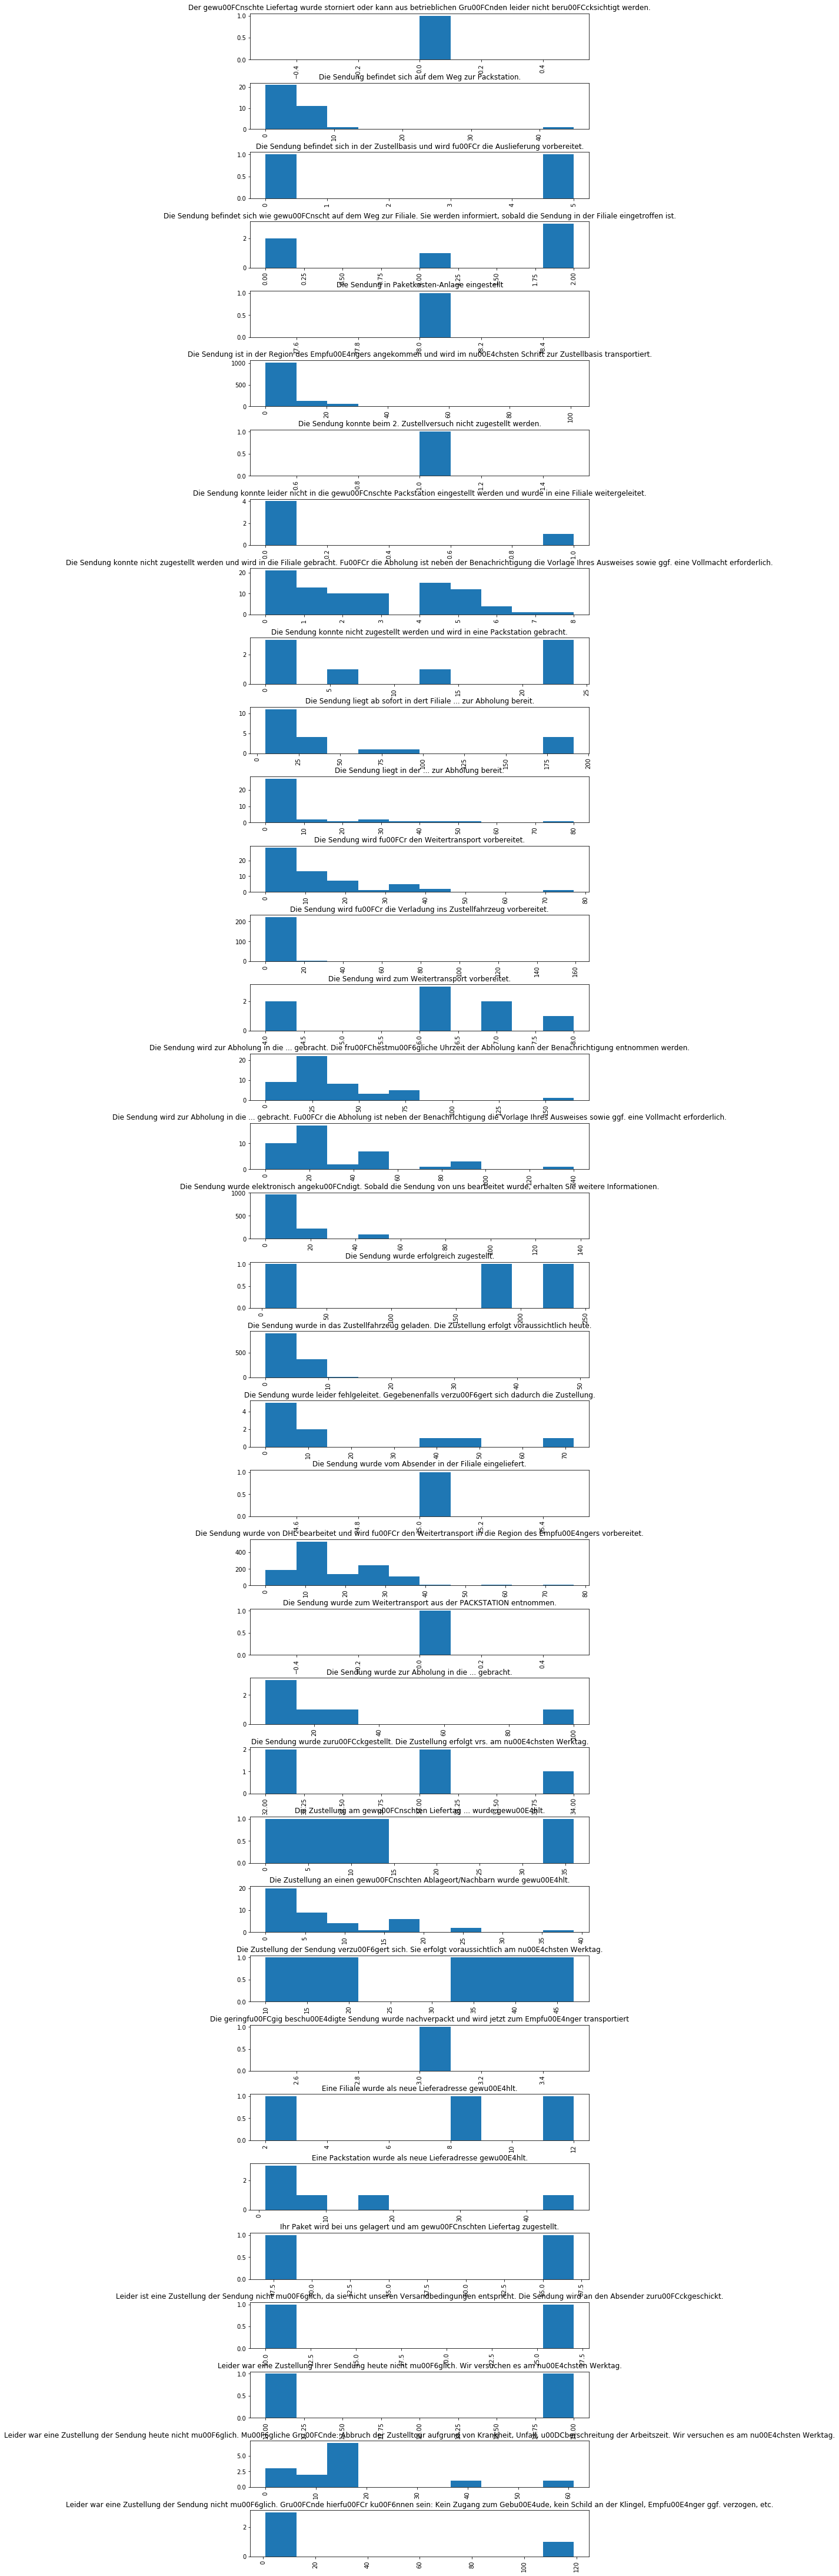

In [47]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['status'], layout=(len(df_temp["status"].unique()), 1), figsize=(10,80))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

In [48]:
df.head()

shipment_number                     datum  \
0  00340434188193339722 2019-11-29 15:27:00+00:00   
1  00340434188193339722 2019-11-30 14:04:00+00:00   
2  00340434188193339722 2019-12-02 21:11:00+00:00   
3  00340434188193339722 2019-12-03 08:33:00+00:00   
4  00340434188193339722 2019-12-03 11:28:00+00:00   

                                              status           ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...     Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...       Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...  Gu00FCnzburg   
3  Die Sendung wurde in das Zustellfahrzeug gelad...     Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.     Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next                datum_next      datum_diff  
0          Hamburg 2019-11-30 14:04:00+00:00 0 days 22:37:00  
1     Gu00FCnzburg 2019-12-02 21:11:00+00:00 2 days 07:07:00  
2        Unbekannt 2019-12-03 08:33:00+00:00 0 days 11:22:00  
3        Unbekannt 2019-12-03 11:28:00+00:00 0 days 02:55:00  
4  SuccessDelivery 2019-12-12 00:00:00+00:00 8 days 12:32:00

### Distribution of time diff for various locations

In [49]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [50]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

datum_diff_h                                             status  \
0          22.0  Die Sendung wurde elektronisch angeku00FCndigt...   
1          55.0  Die Sendung wurde von DHL bearbeitet und wird ...   
2          11.0  Die Sendung ist in der Region des Empfu00E4nge...   
3           2.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
4           3.0  Die Sendung wurde elektronisch angeku00FCndigt...   

            ort  
0     Unbekannt  
1       Hamburg  
2  Gu00FCnzburg  
3     Unbekannt  
4     Unbekannt

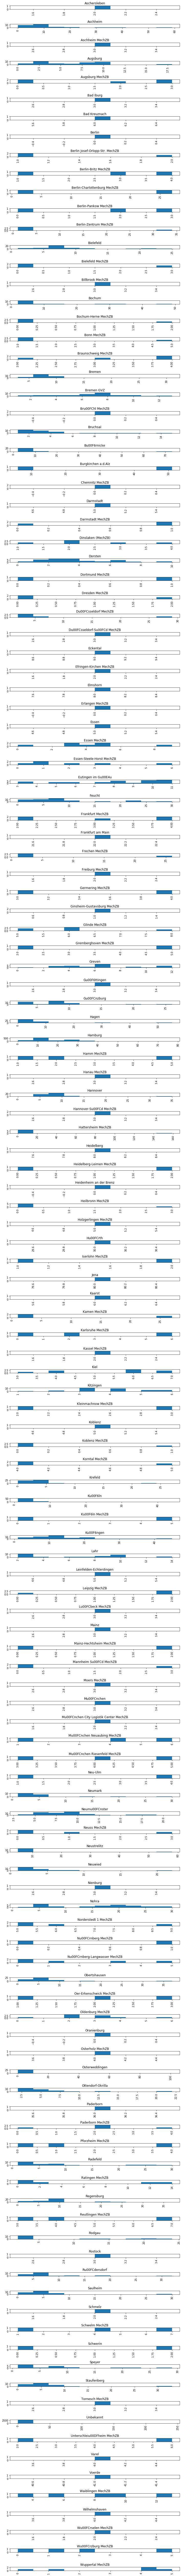

In [51]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['ort'], layout=(len(df_temp["ort"].unique()), 1), figsize=(10,140))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

### Distribution of time diff for various locations and states

In [52]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [53]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

datum_diff_h                                             status  \
0          22.0  Die Sendung wurde elektronisch angeku00FCndigt...   
1          55.0  Die Sendung wurde von DHL bearbeitet und wird ...   
2          11.0  Die Sendung ist in der Region des Empfu00E4nge...   
3           2.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
4           3.0  Die Sendung wurde elektronisch angeku00FCndigt...   

            ort  
0     Unbekannt  
1       Hamburg  
2  Gu00FCnzburg  
3     Unbekannt  
4     Unbekannt

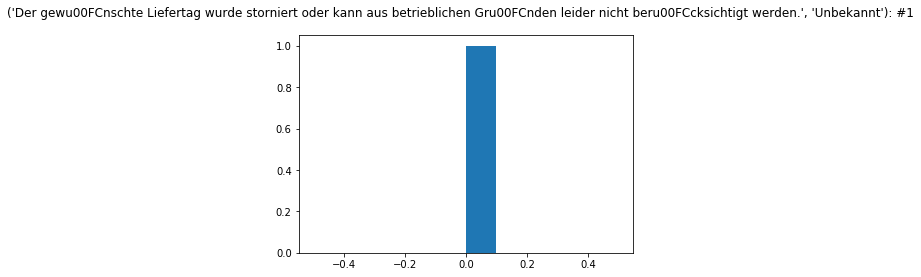

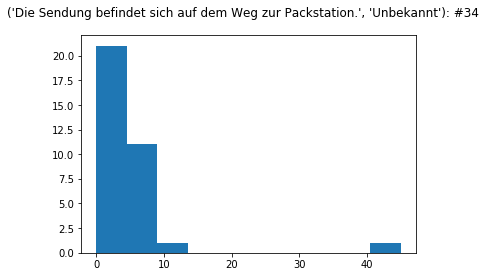

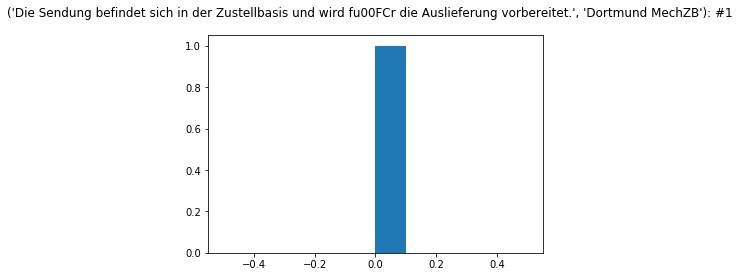

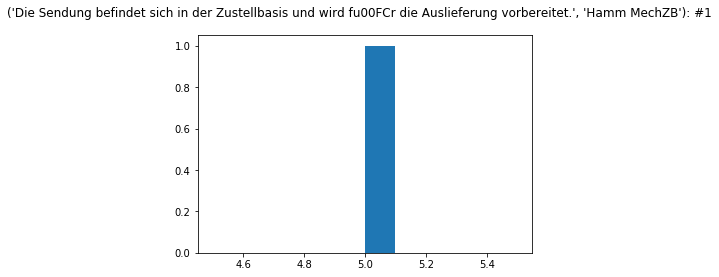

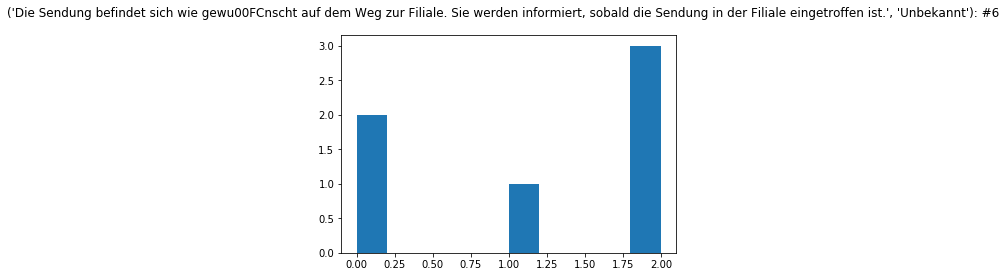

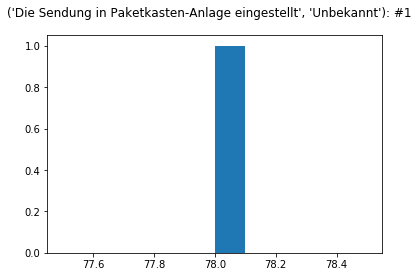

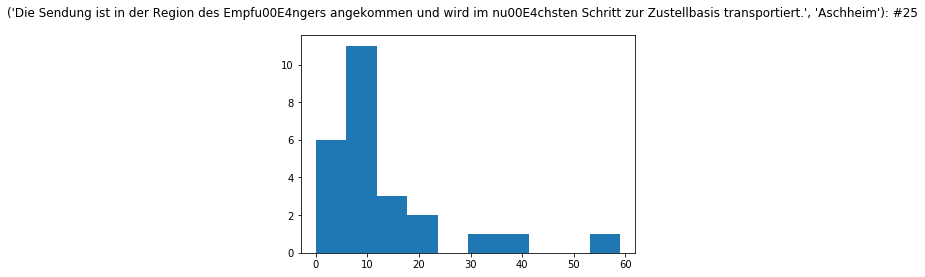

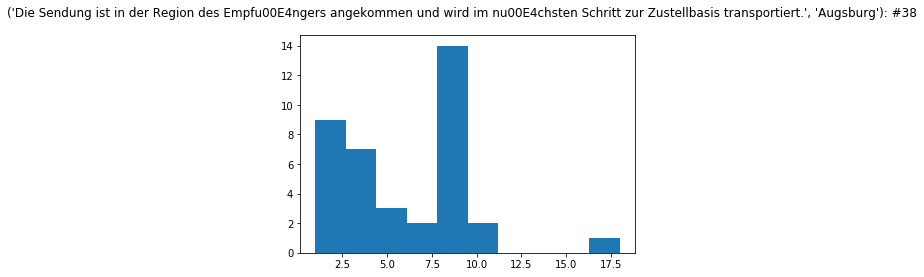

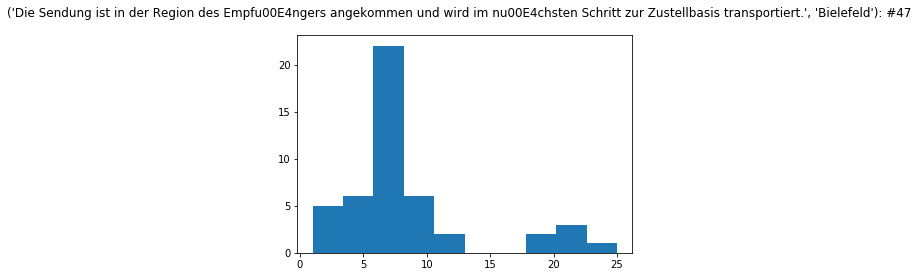

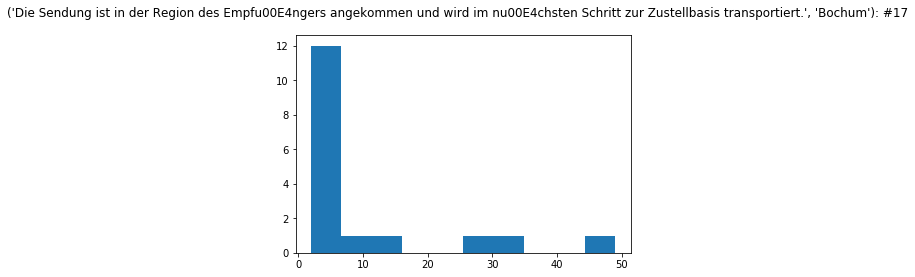

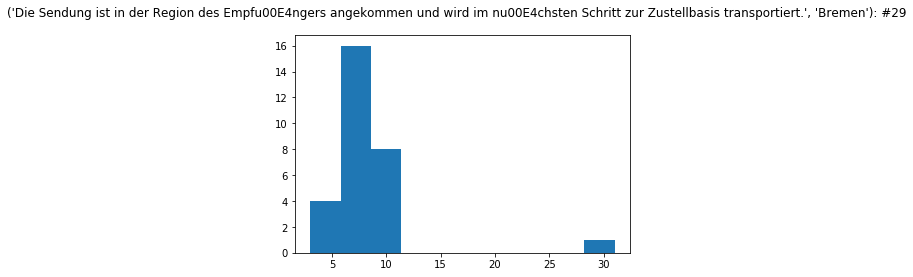

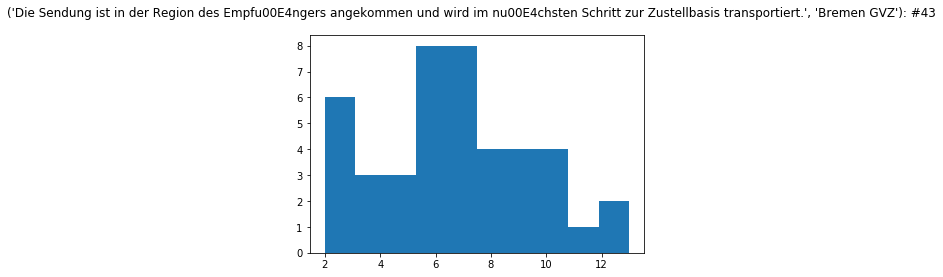

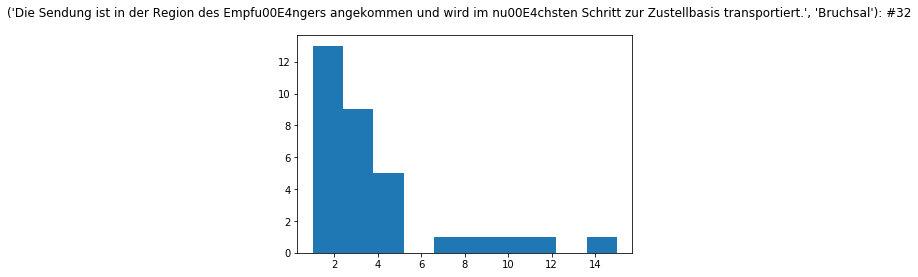

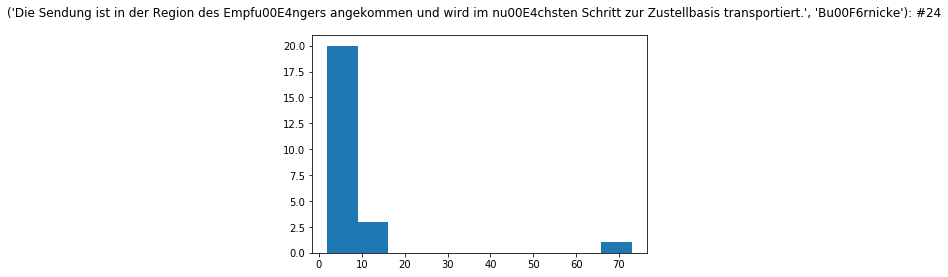

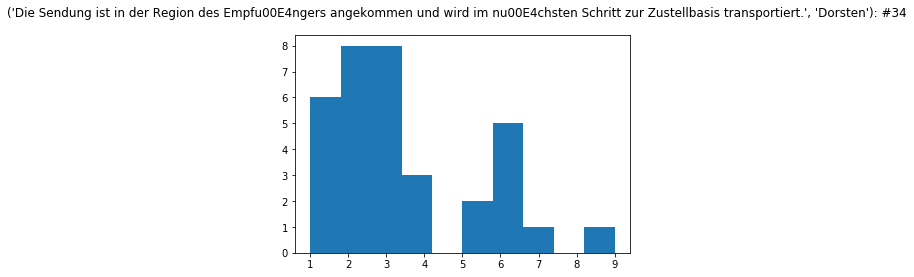

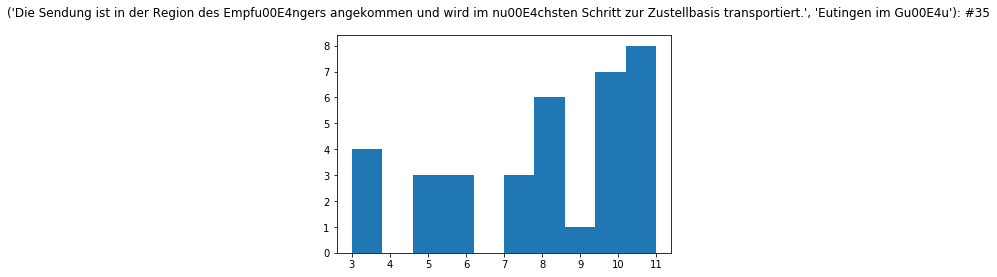

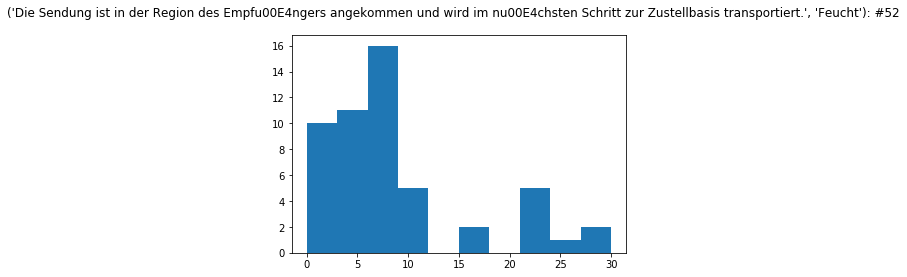

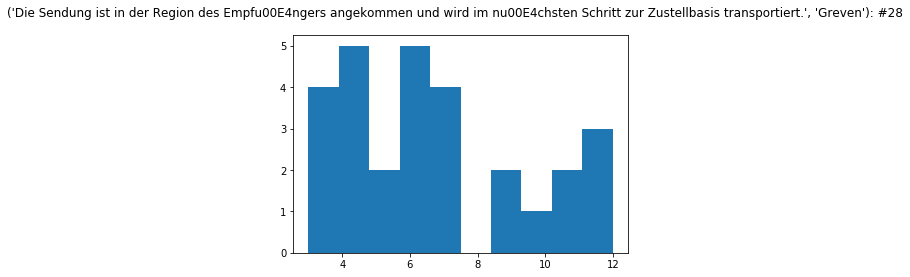

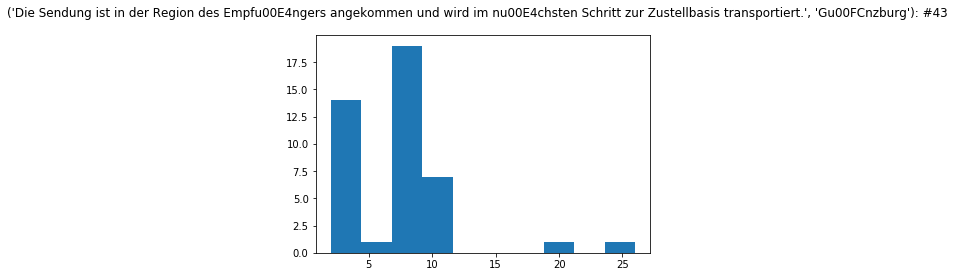

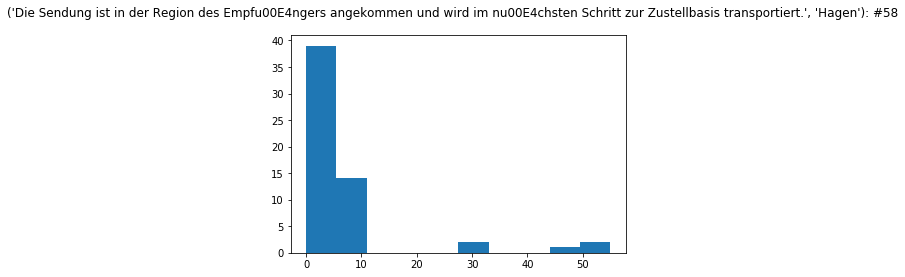

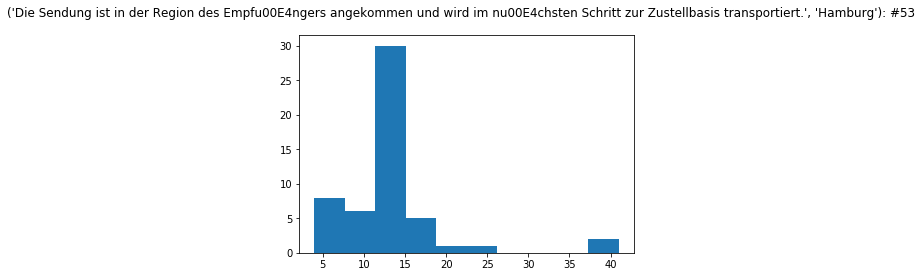

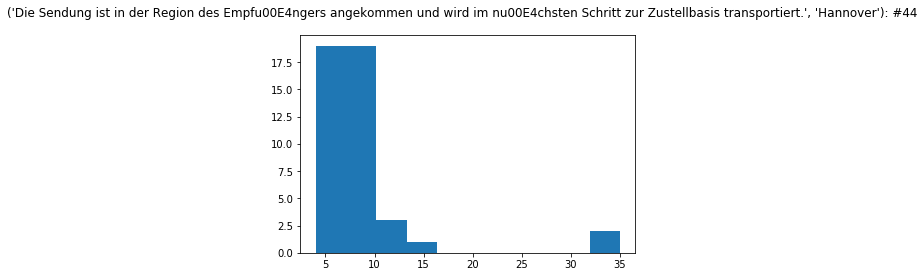

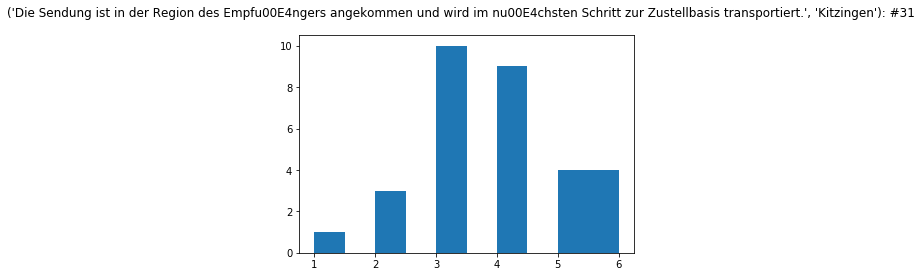

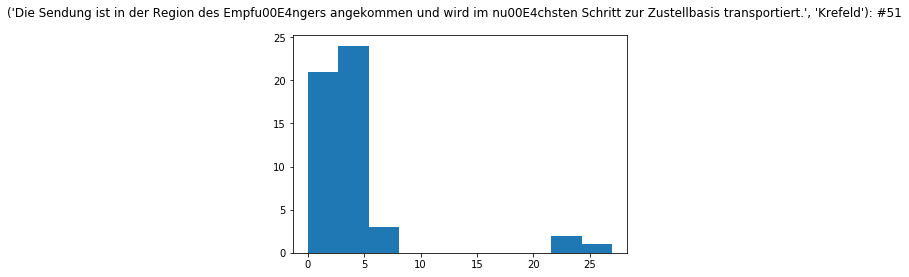

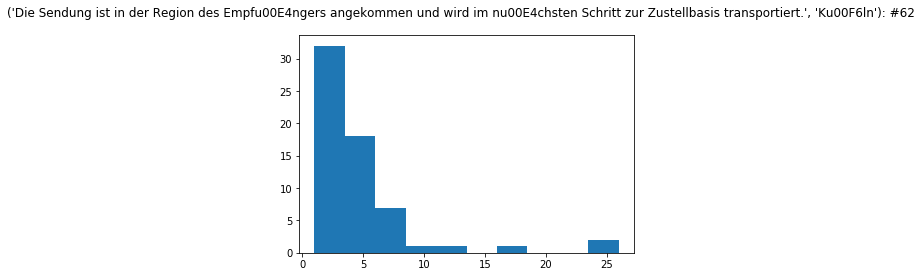

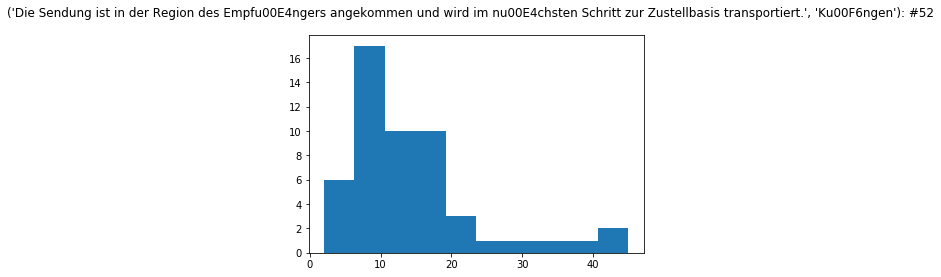

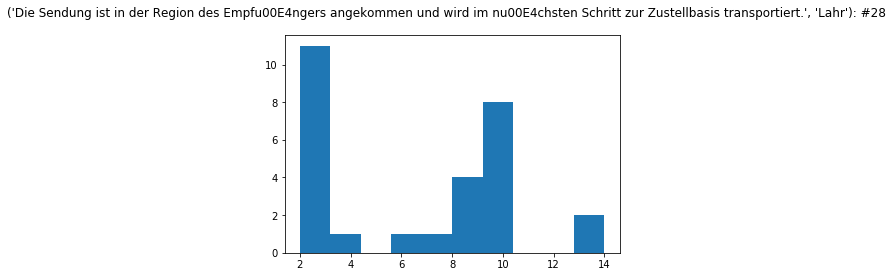

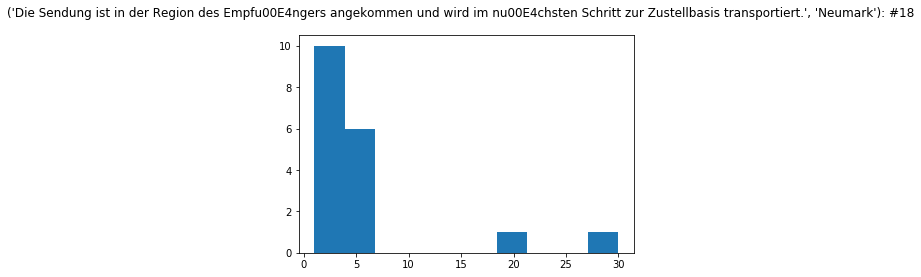

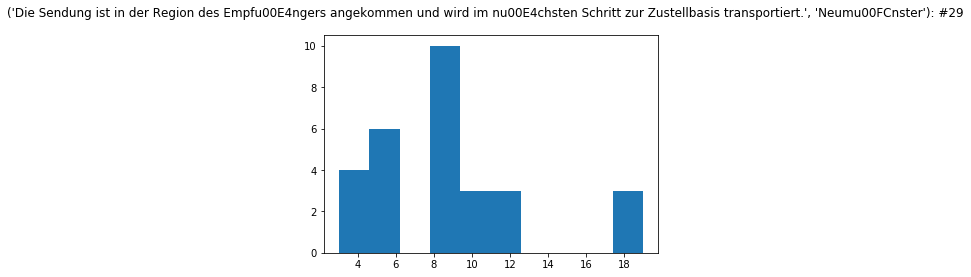

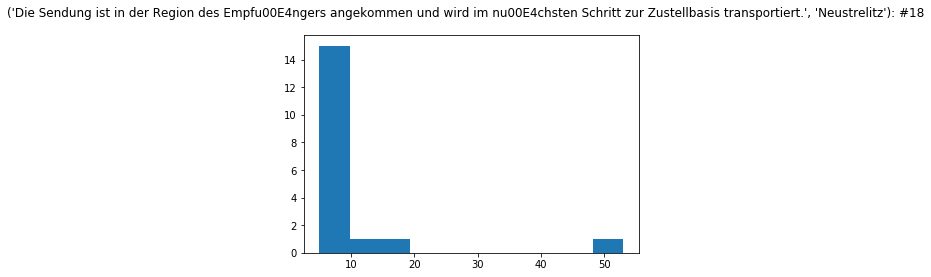

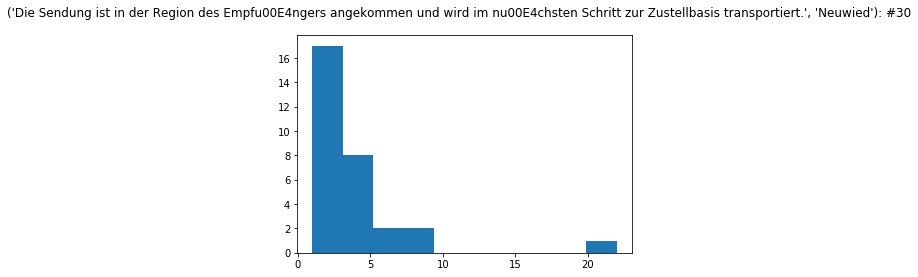

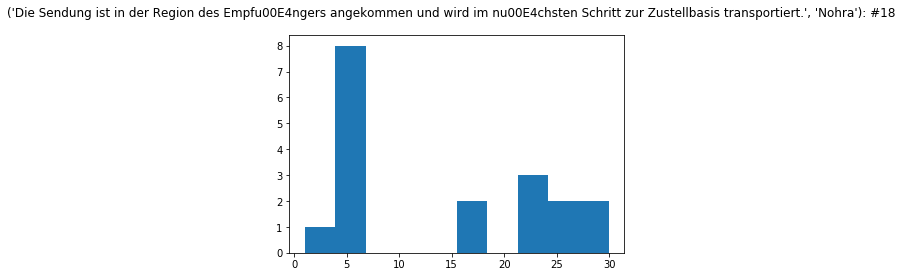

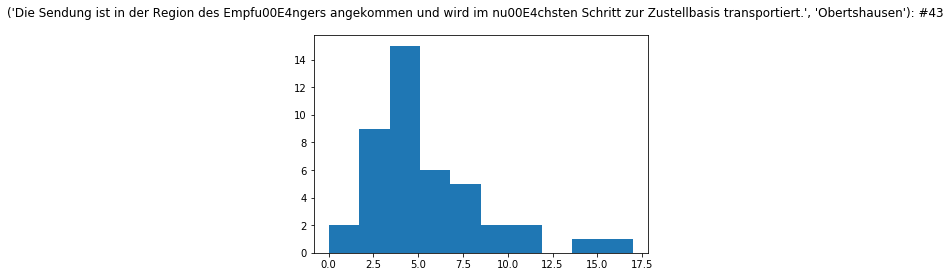

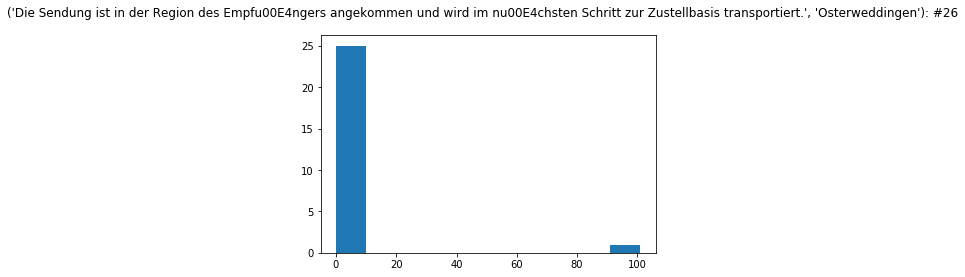

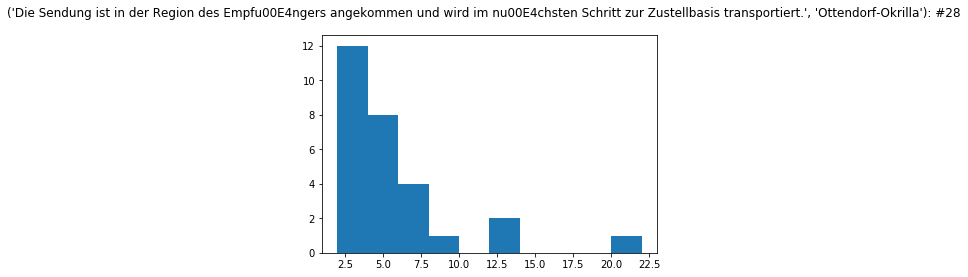

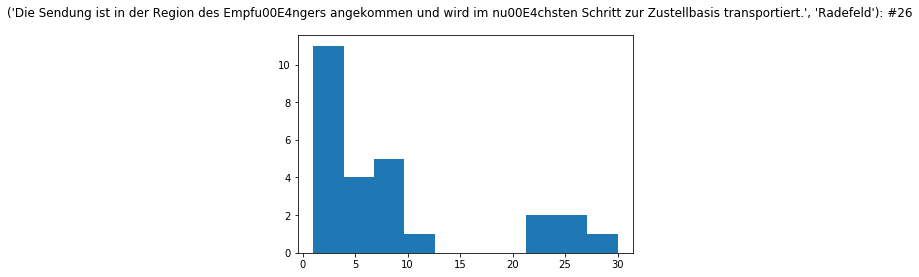

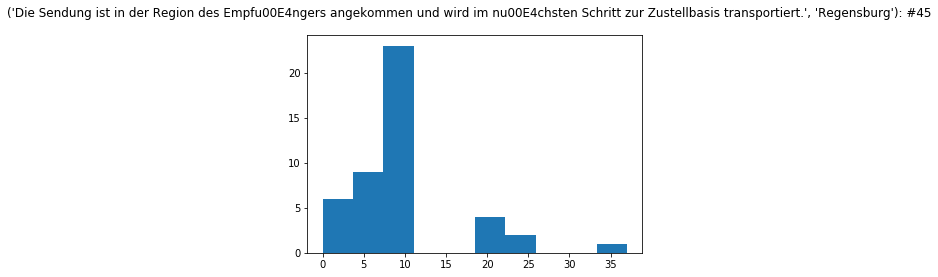

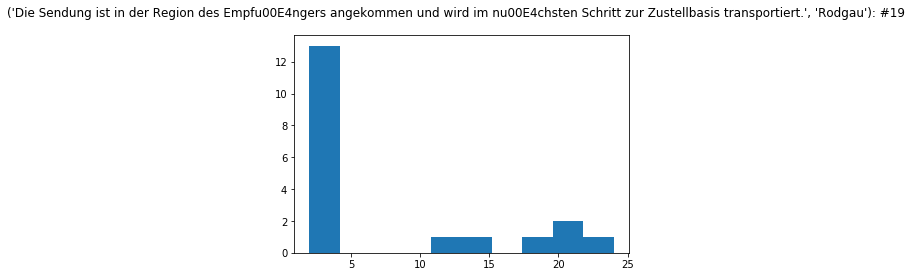

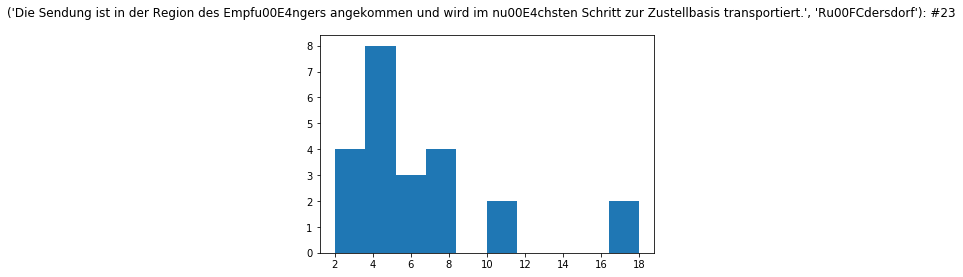

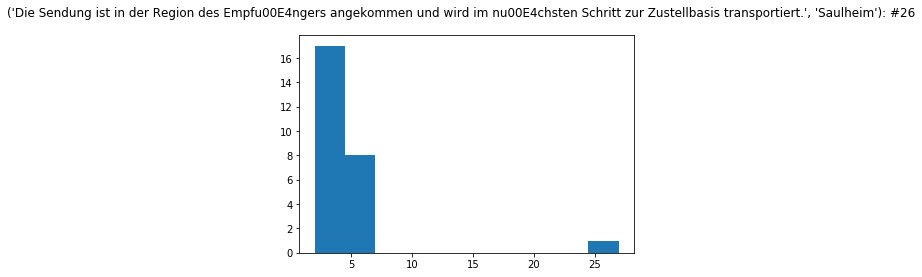

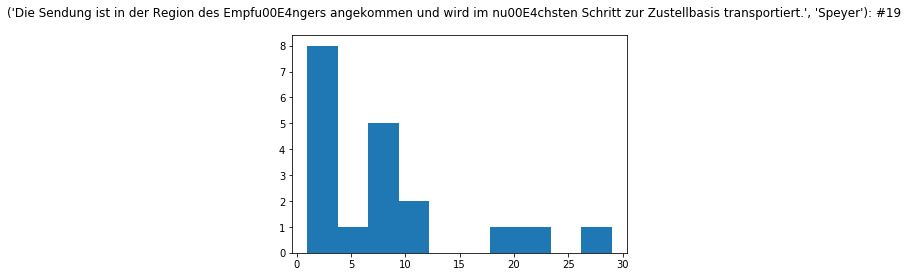

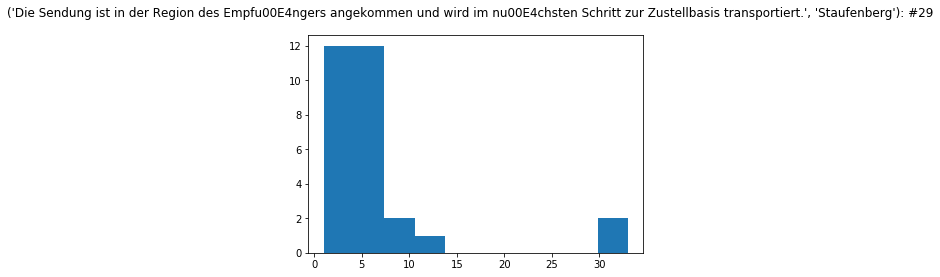

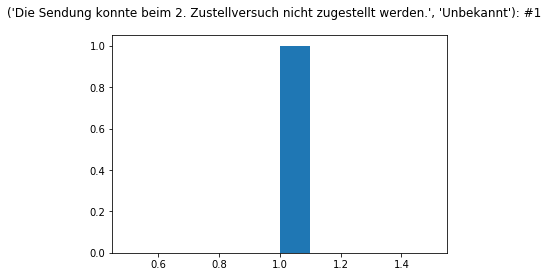

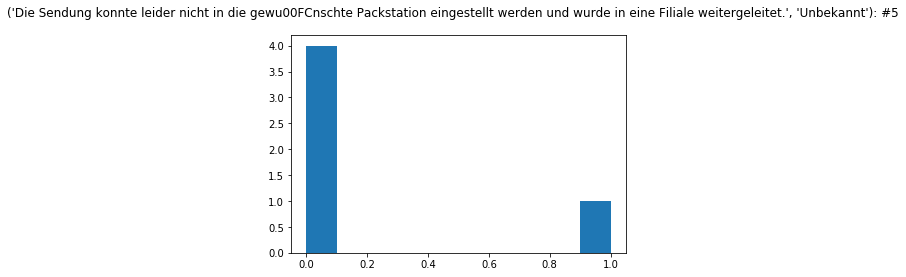

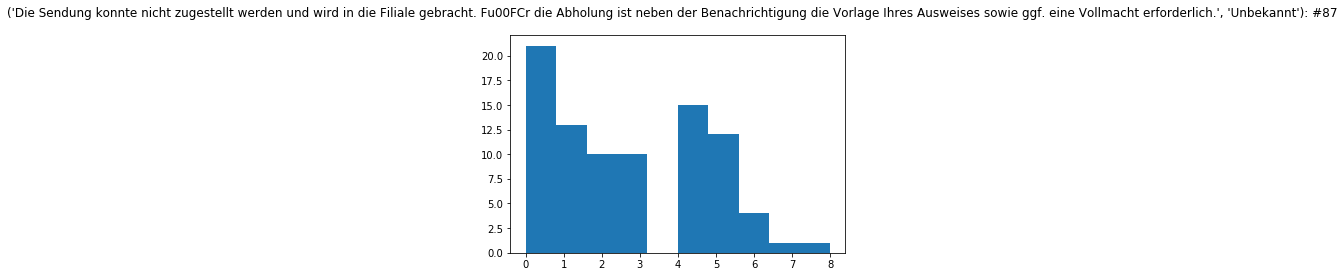

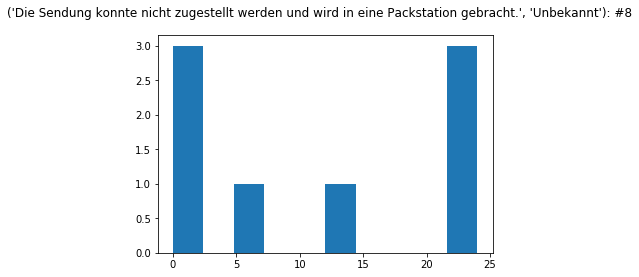

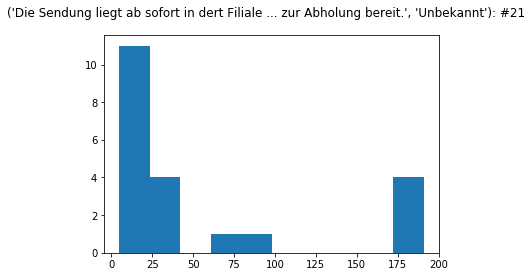

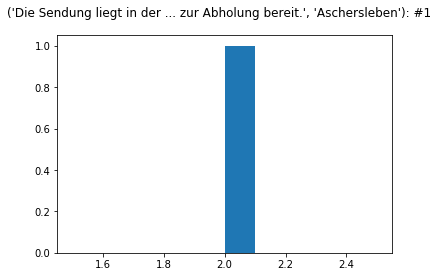

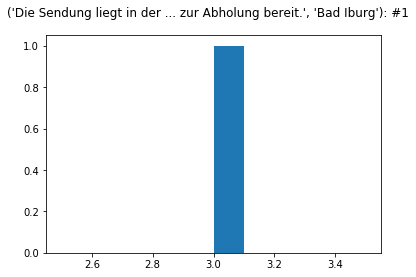

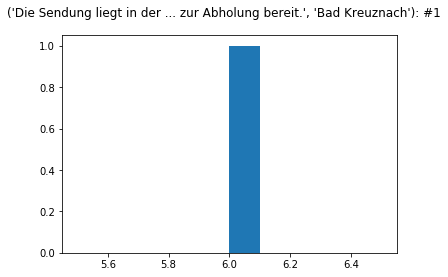

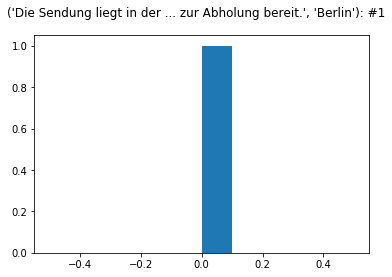

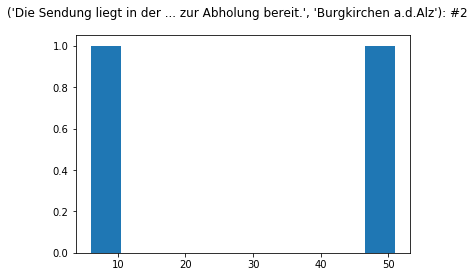

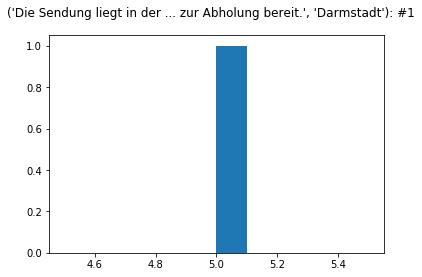

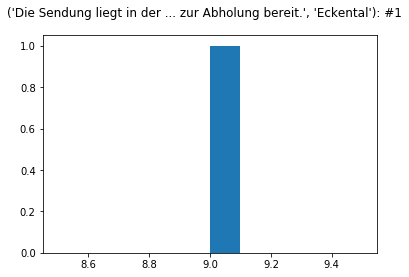

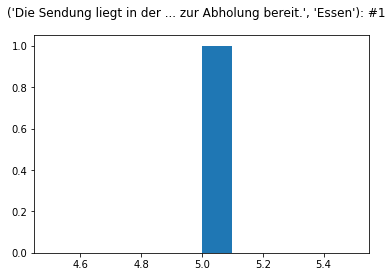

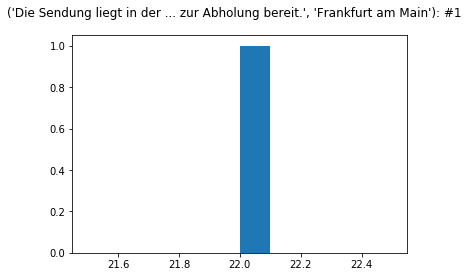

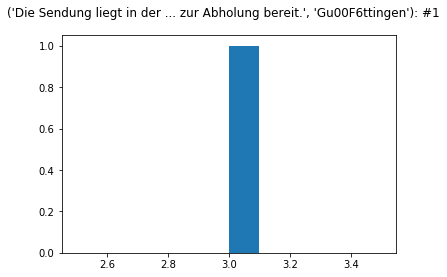

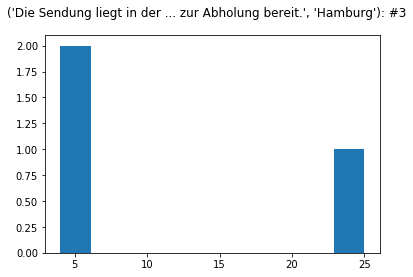

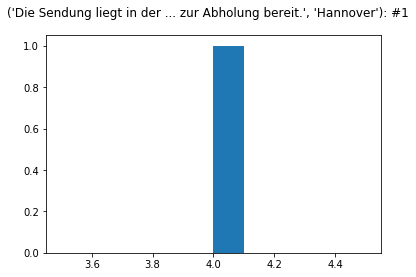

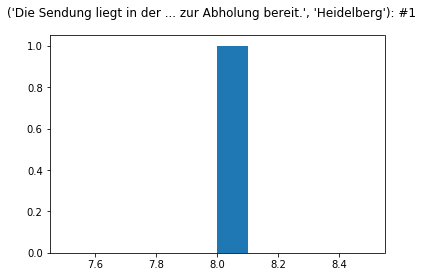

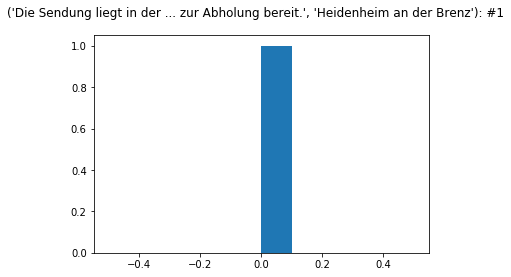

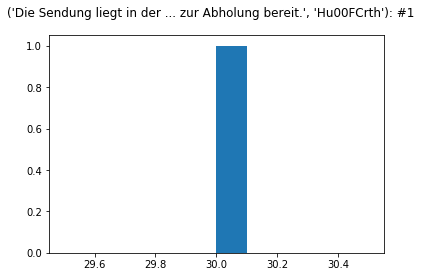

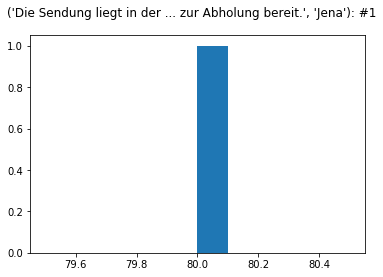

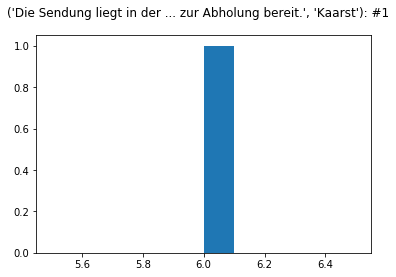

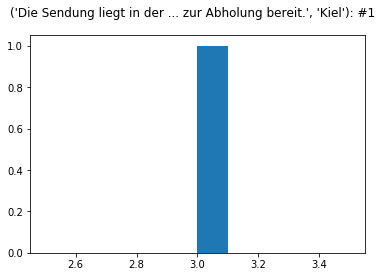

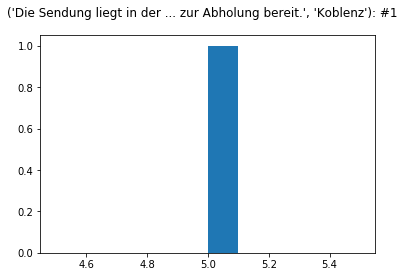

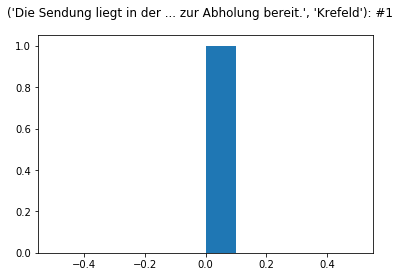

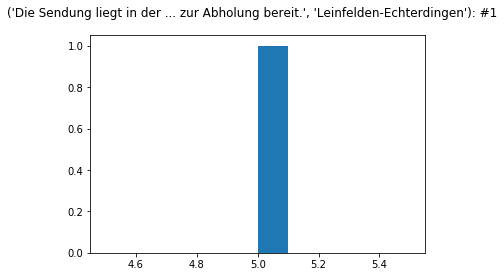

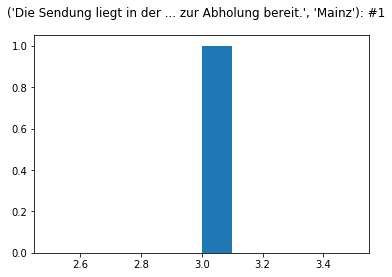

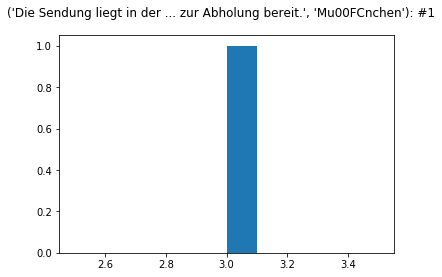

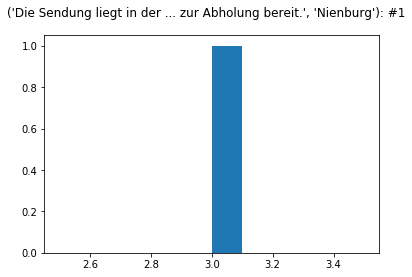

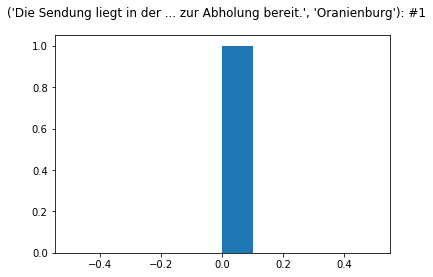

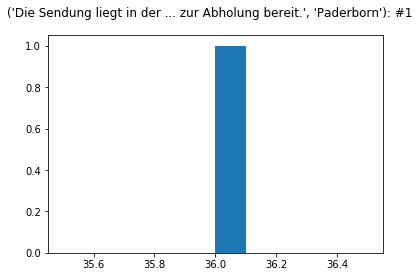

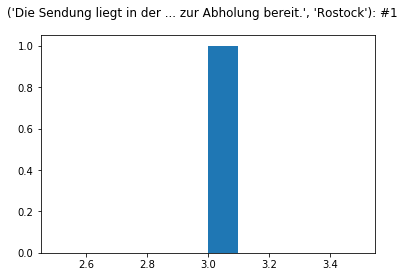

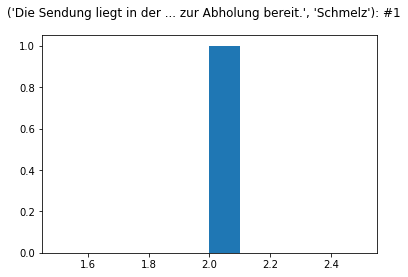

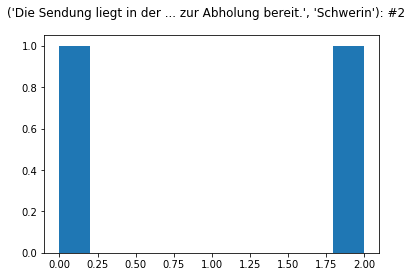

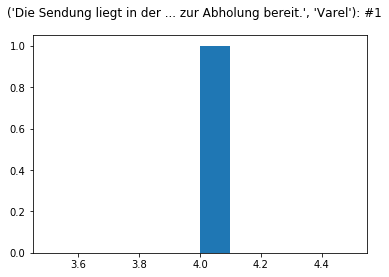

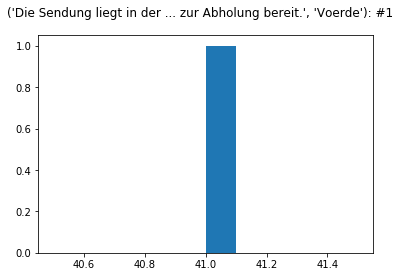

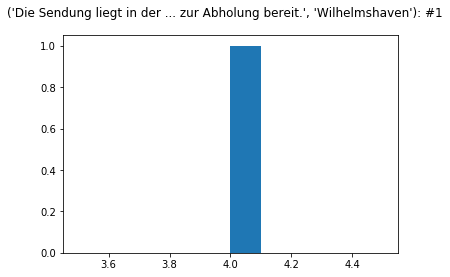

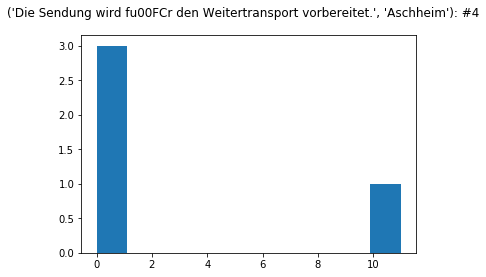

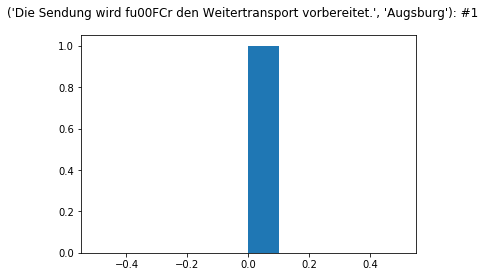

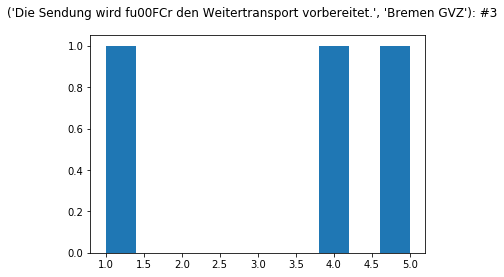

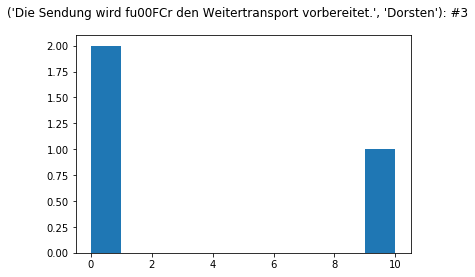

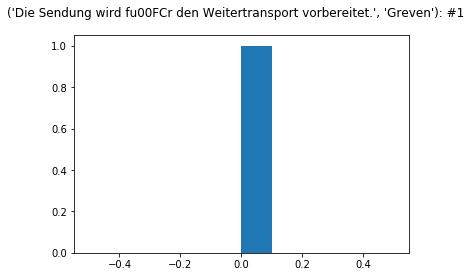

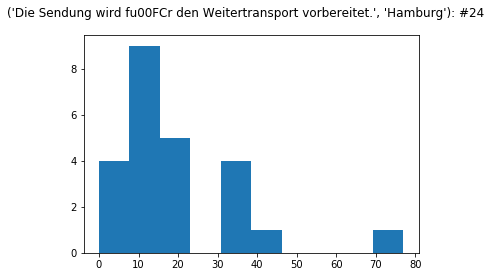

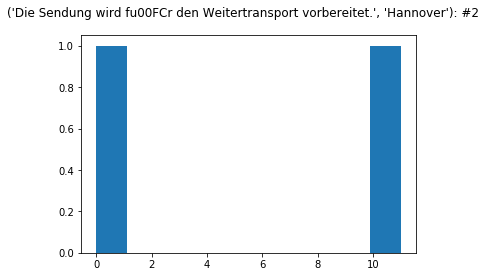

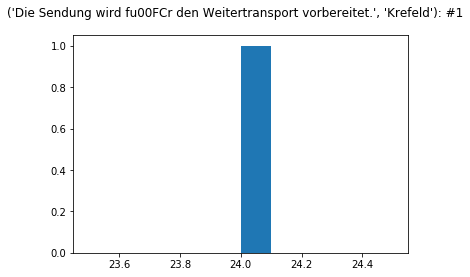

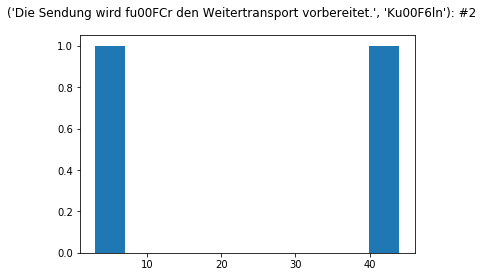

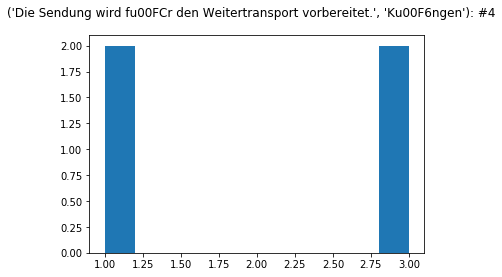

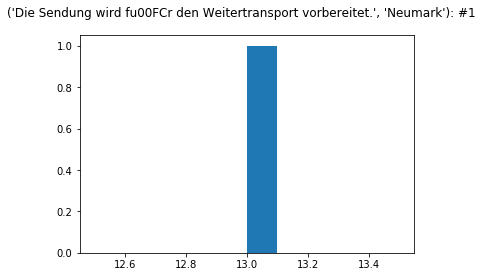

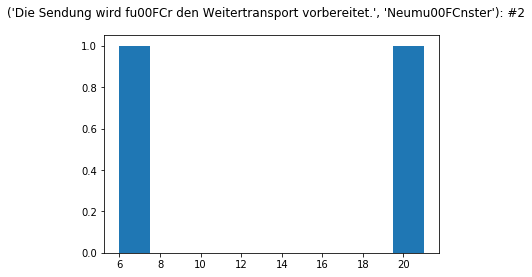

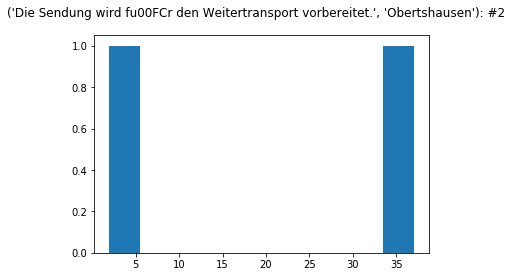

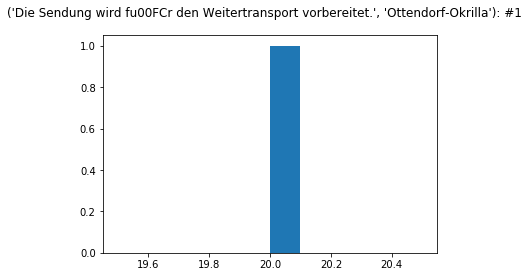

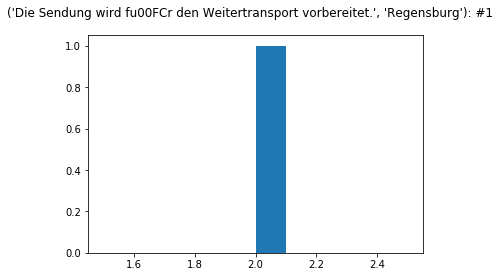

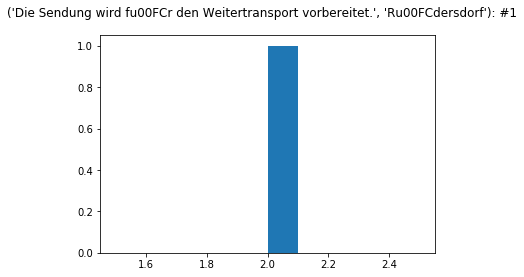

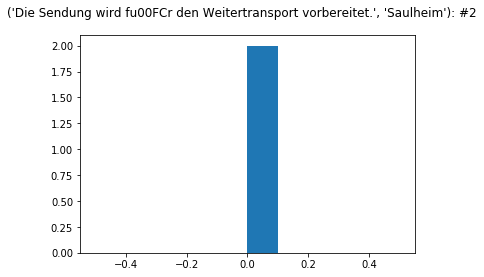

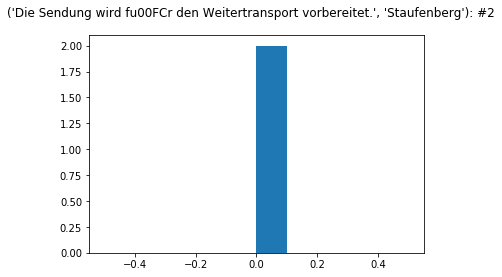

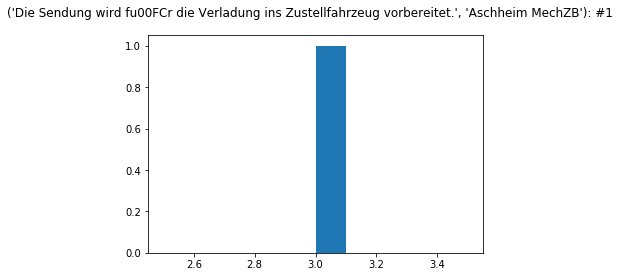

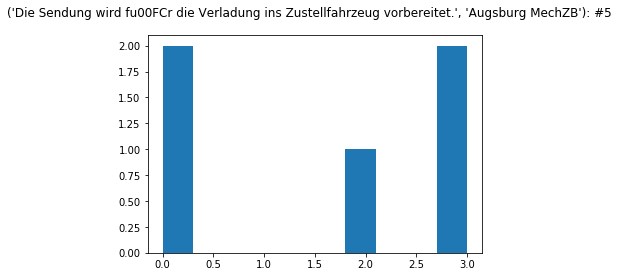

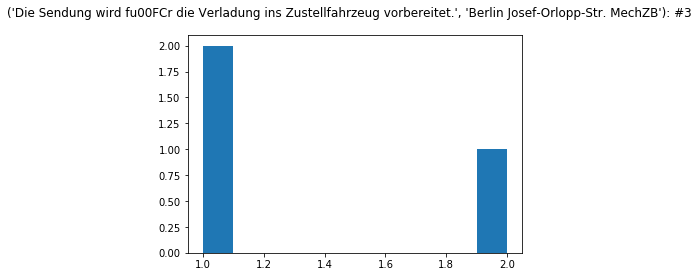

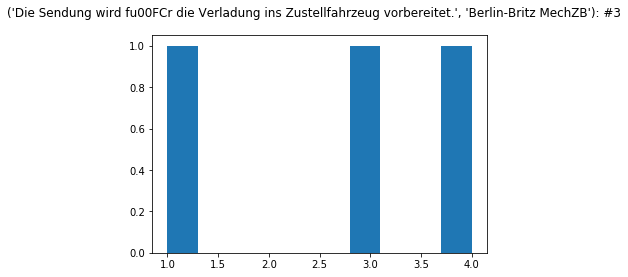

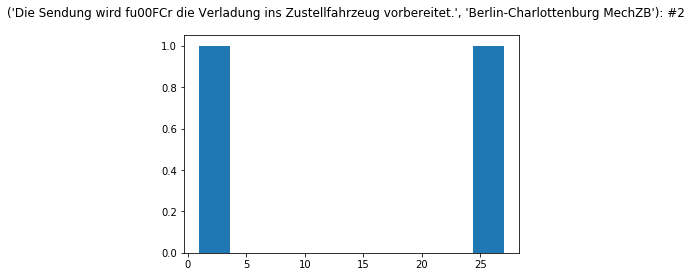

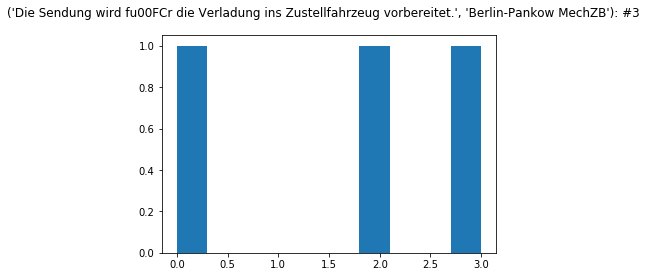

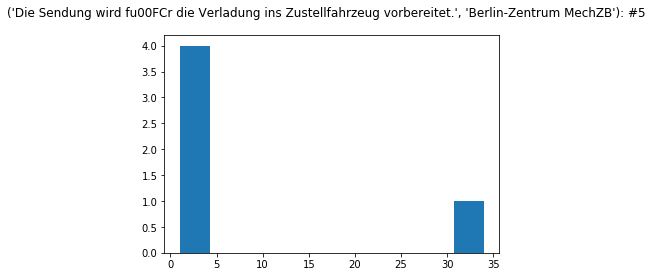

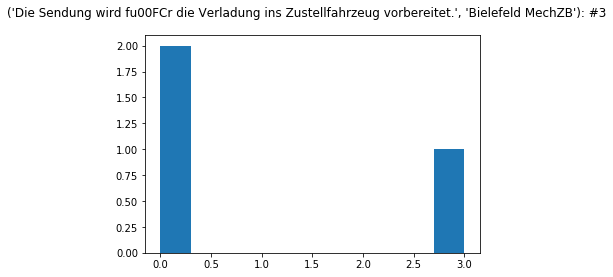

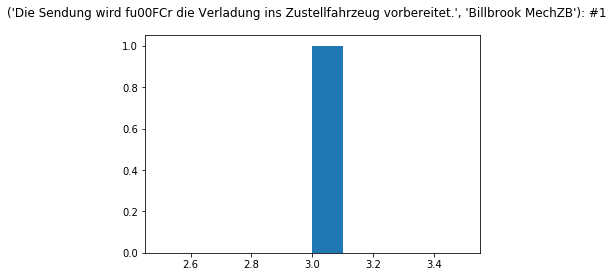

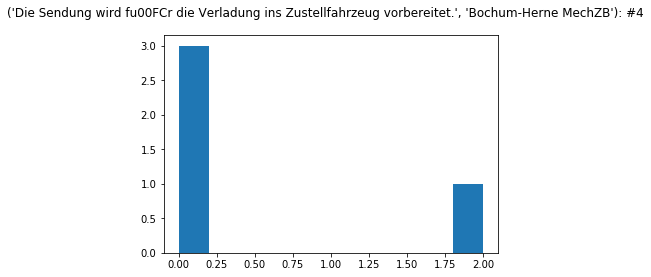

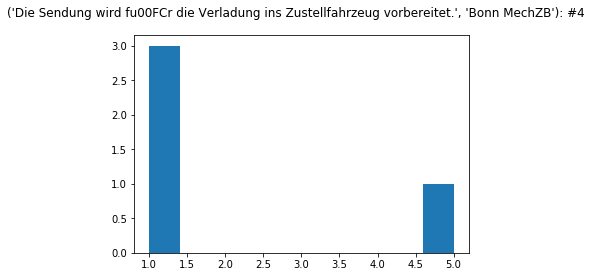

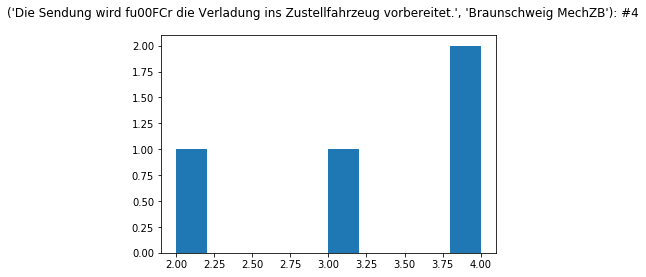

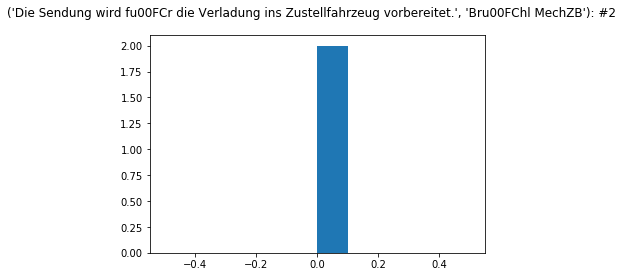

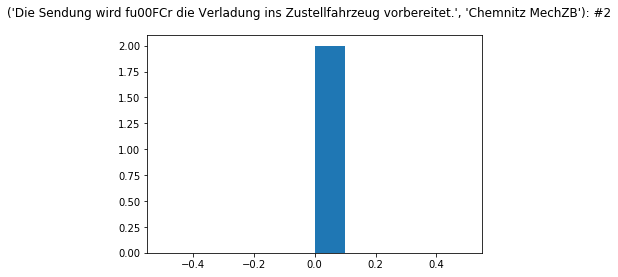

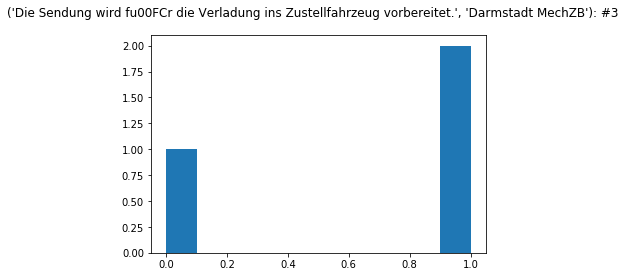

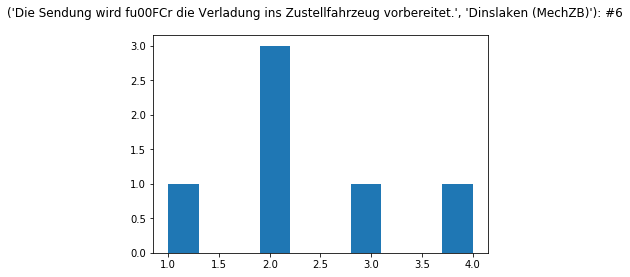

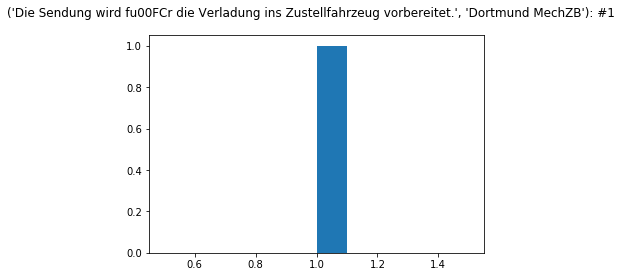

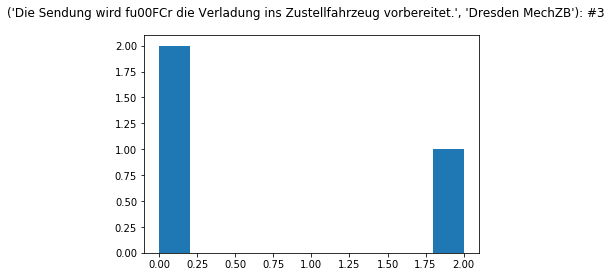

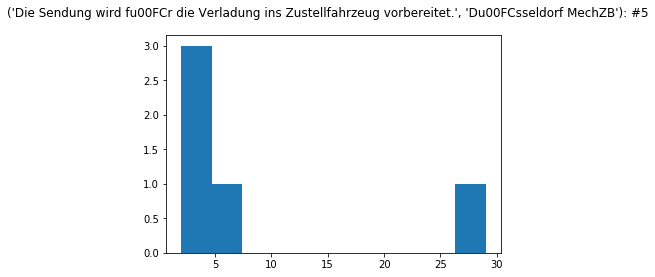

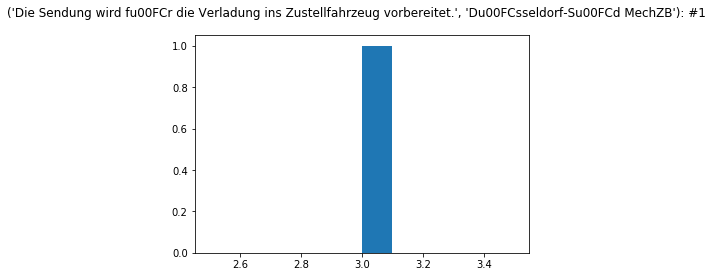

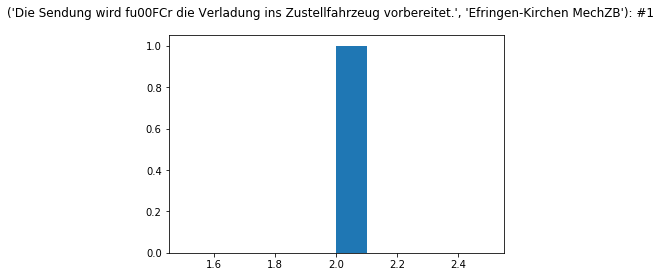

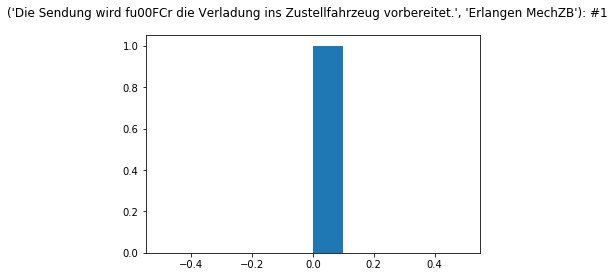

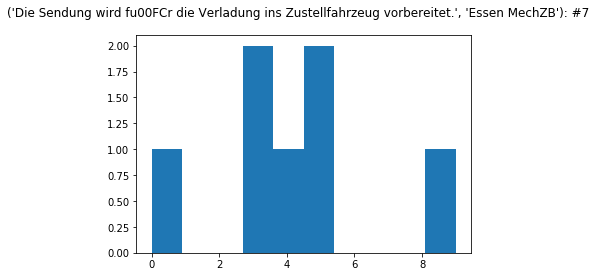

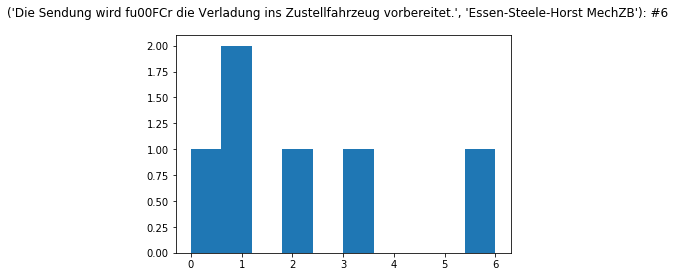

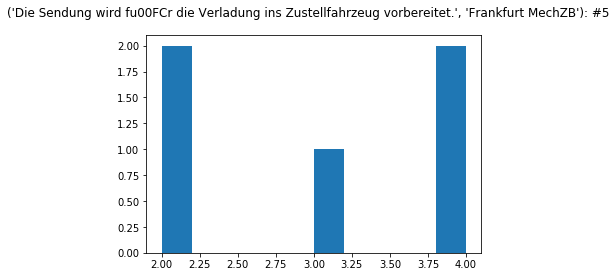

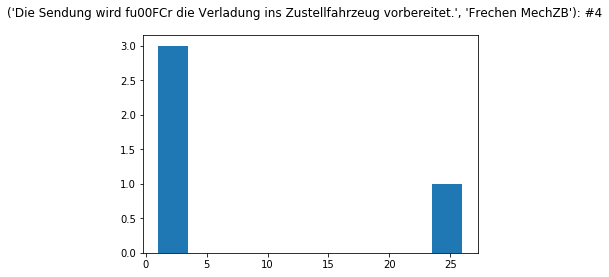

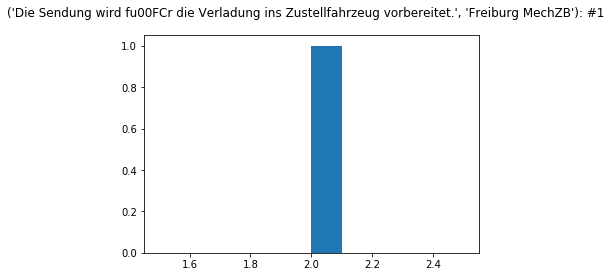

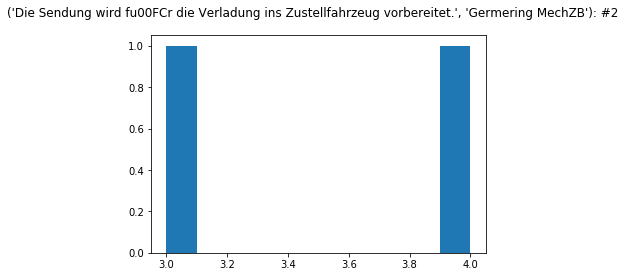

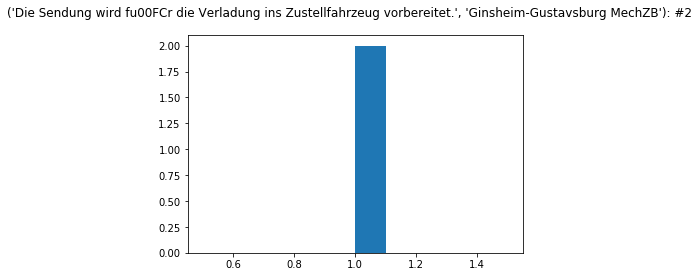

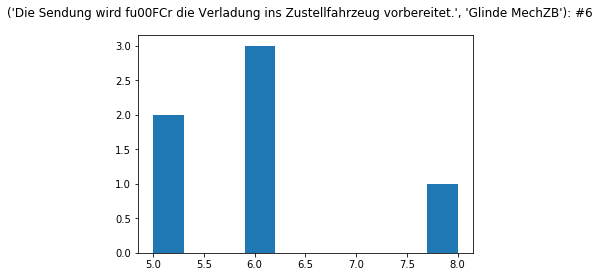

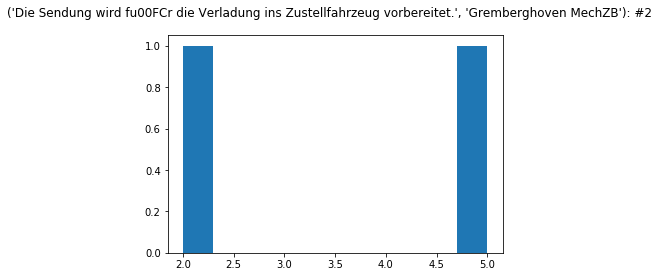

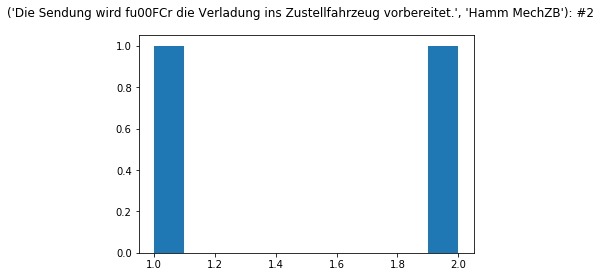

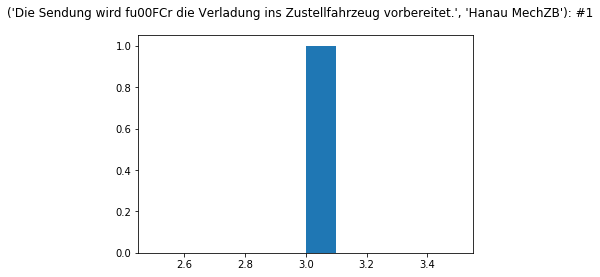

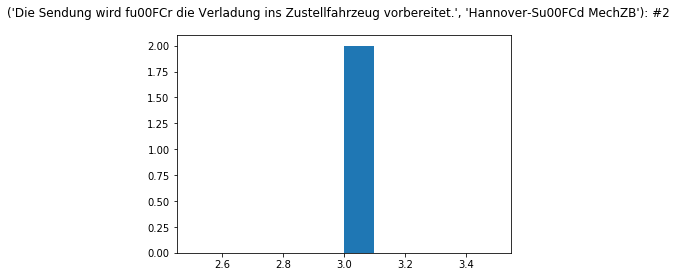

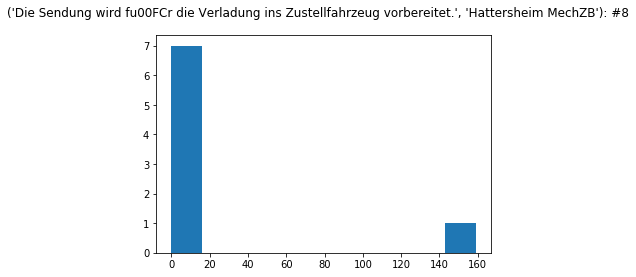

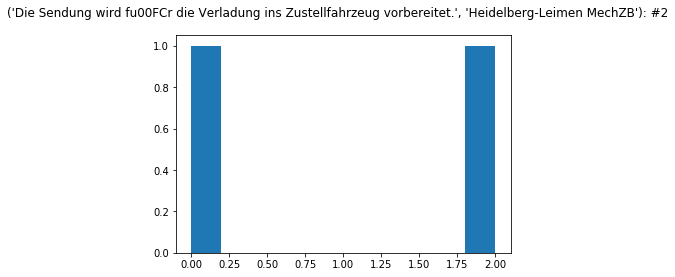

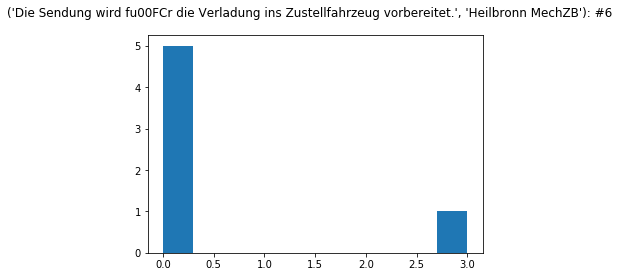

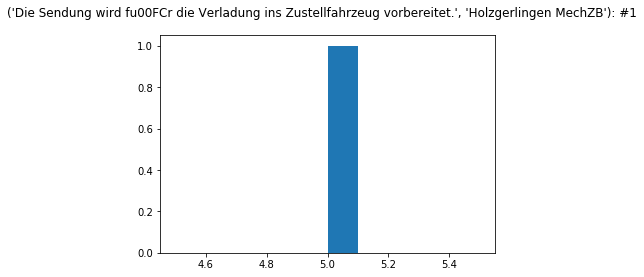

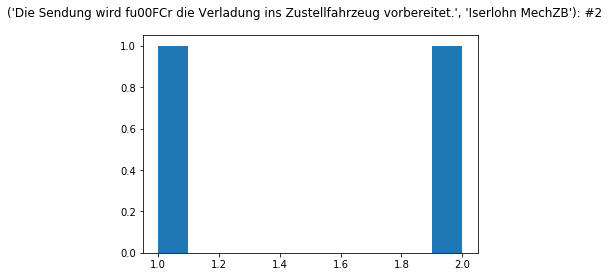

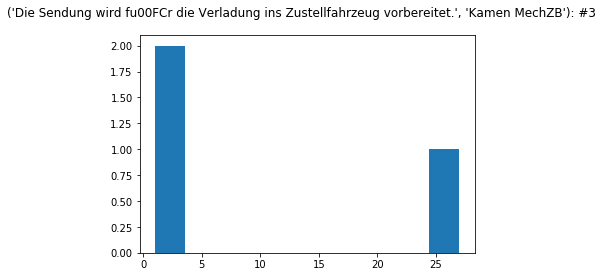

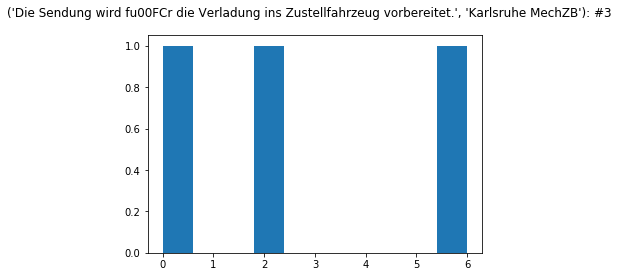

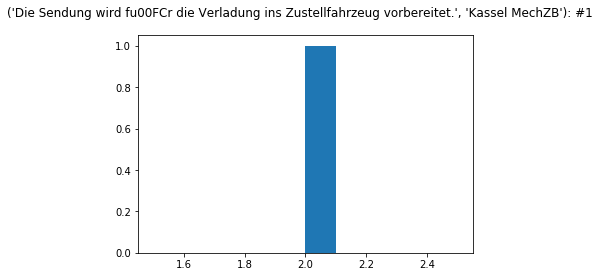

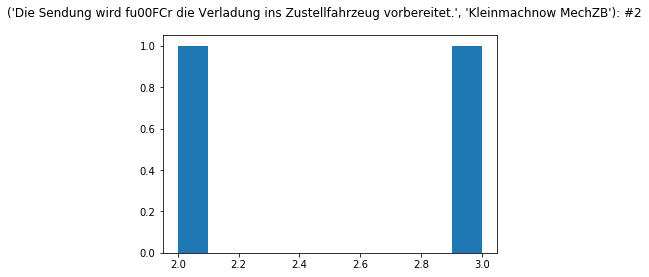

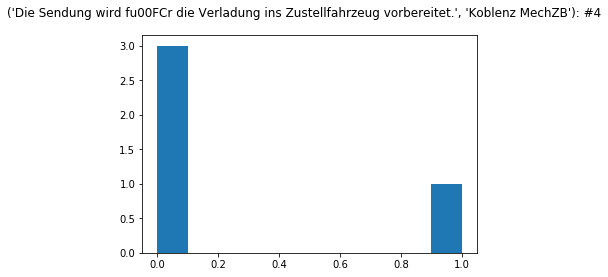

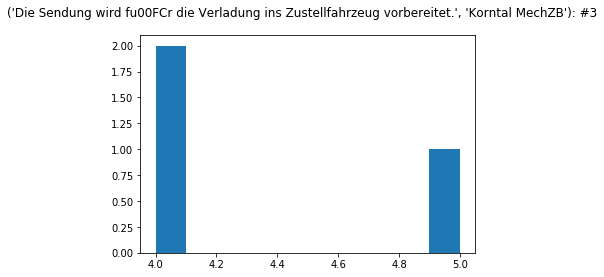

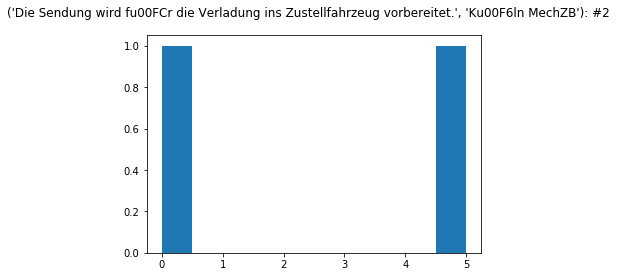

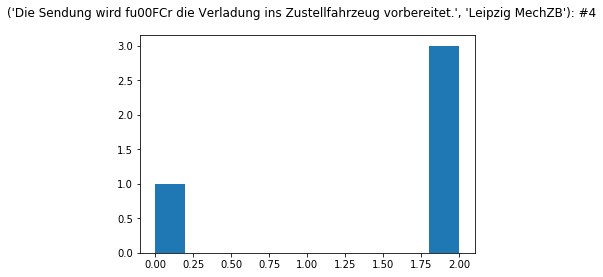

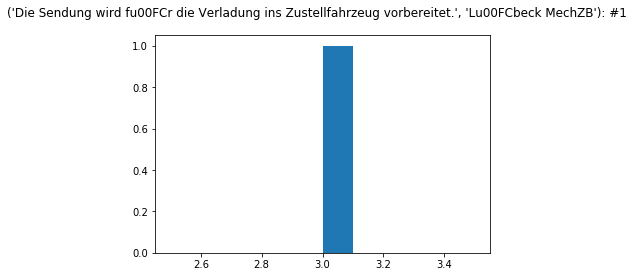

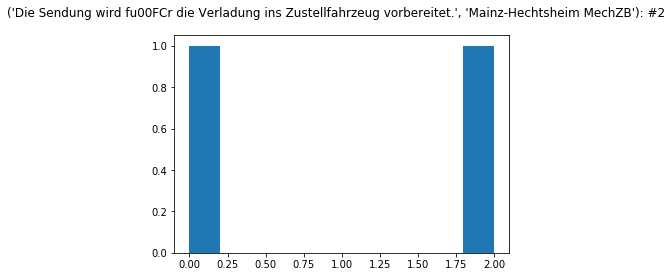

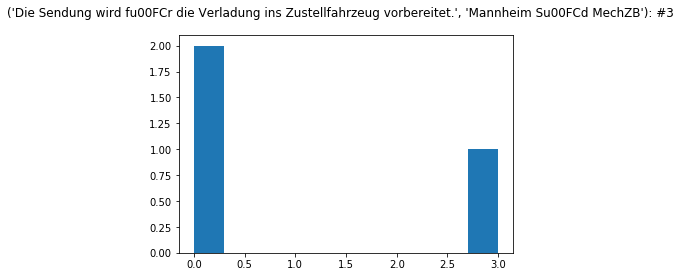

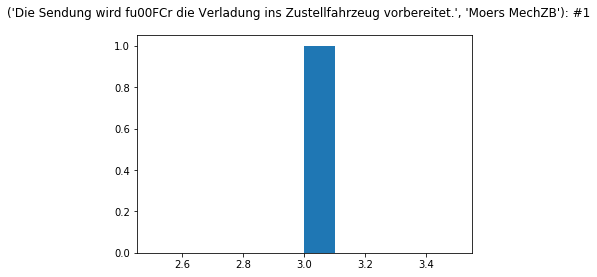

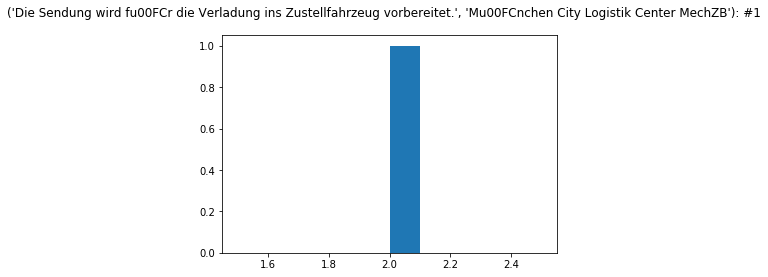

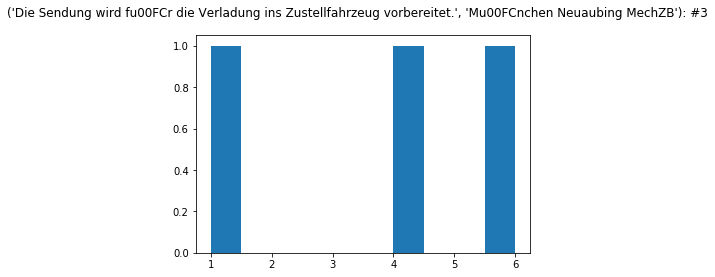

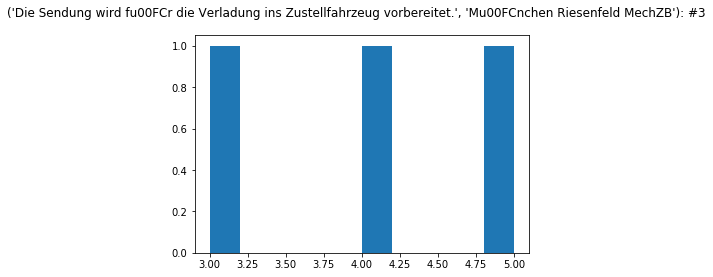

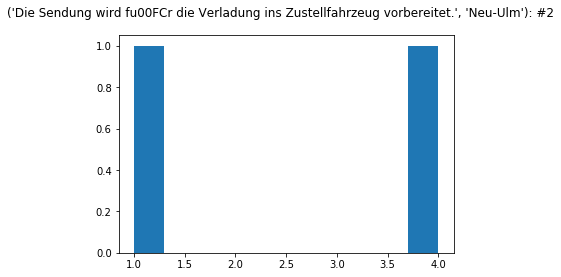

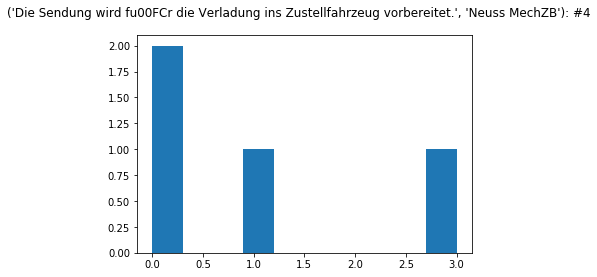

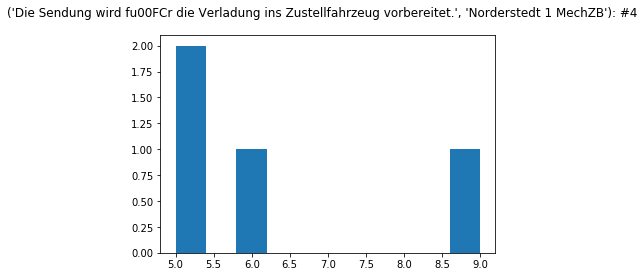

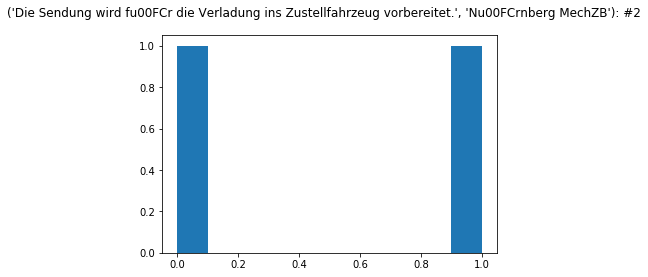

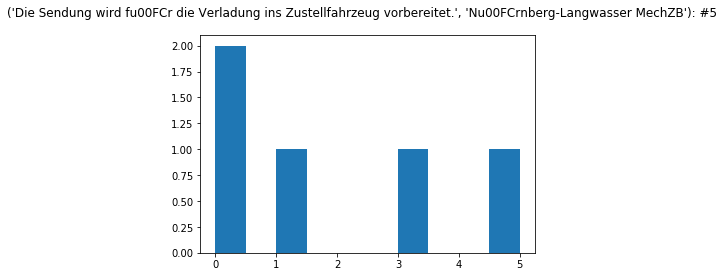

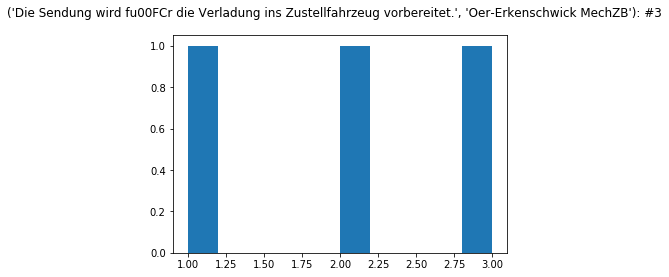

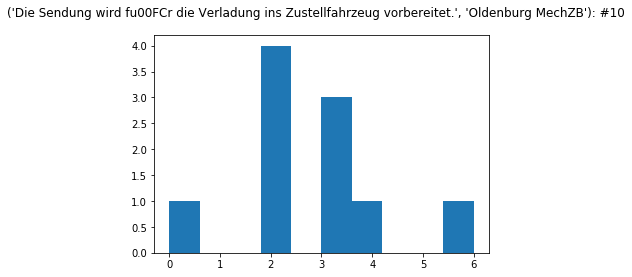

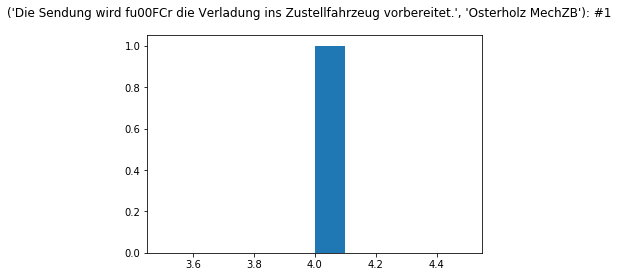

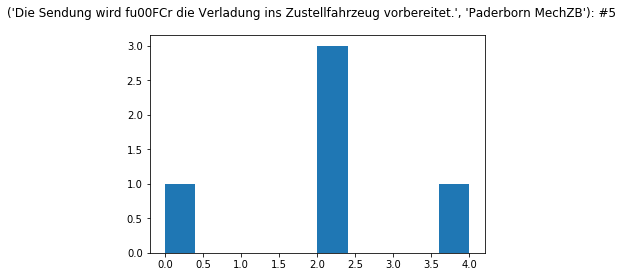

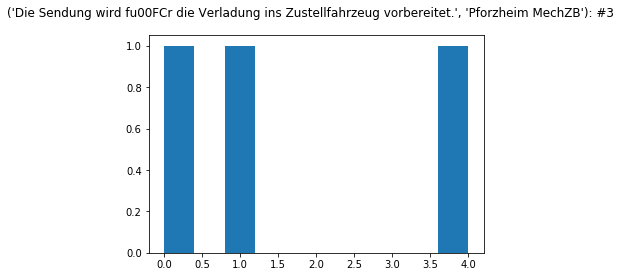

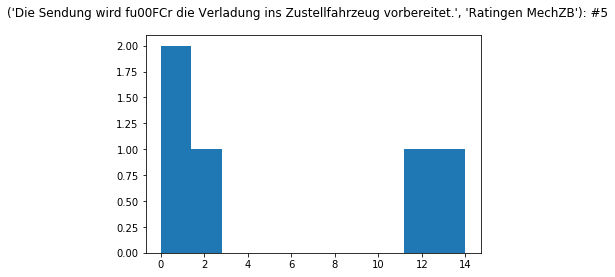

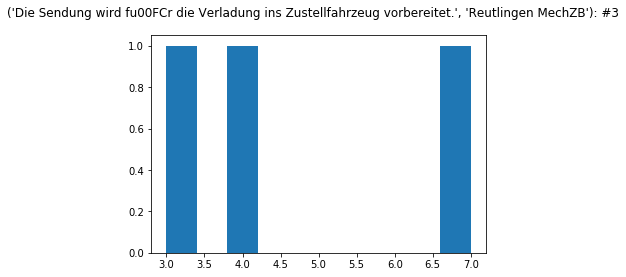

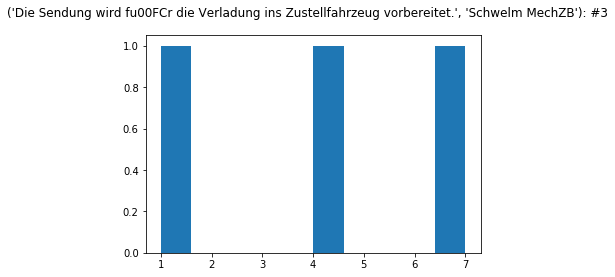

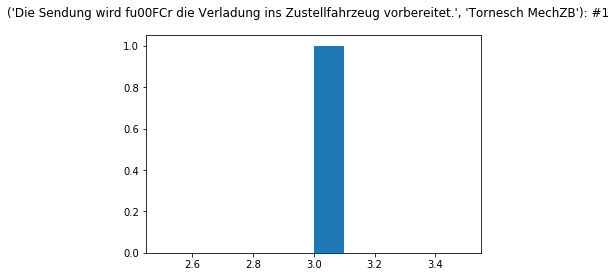

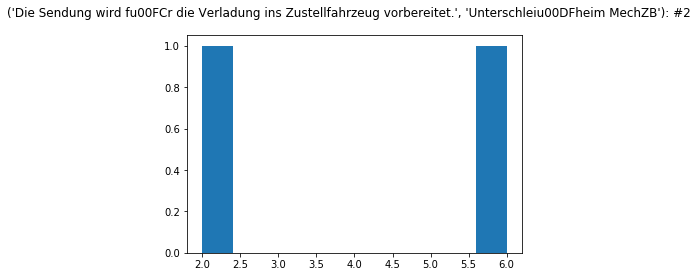

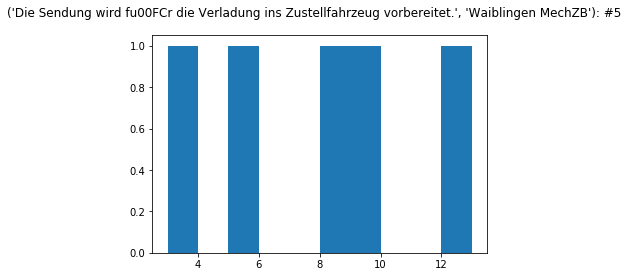

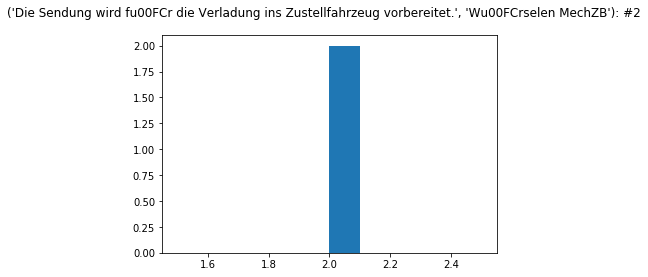

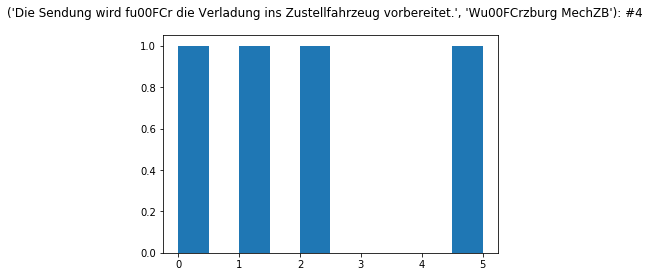

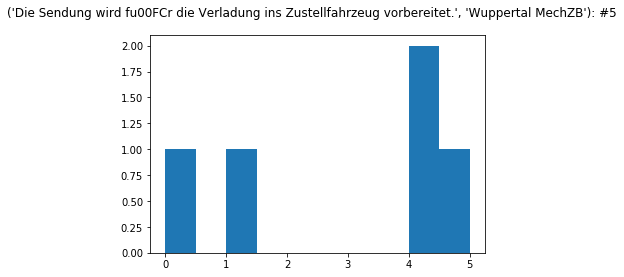

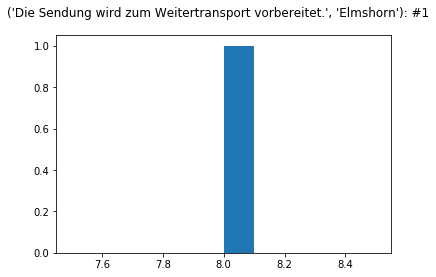

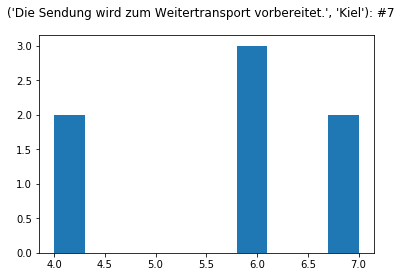

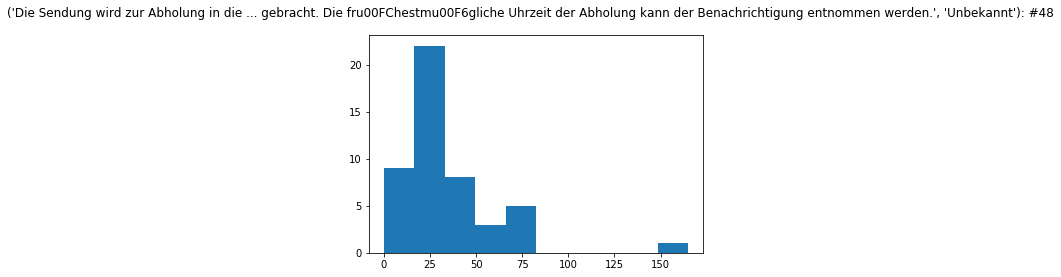

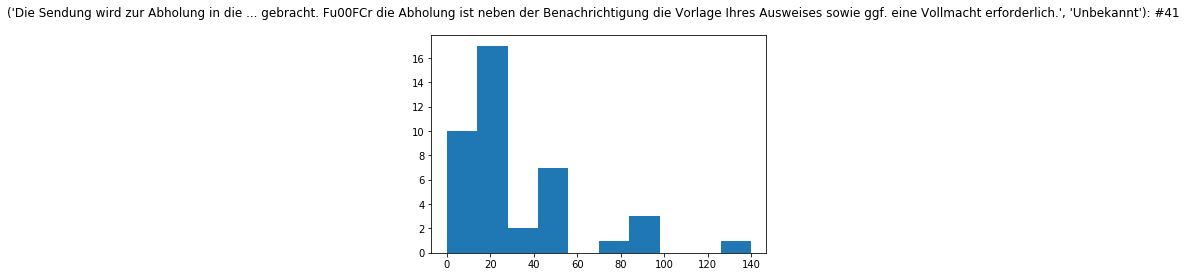

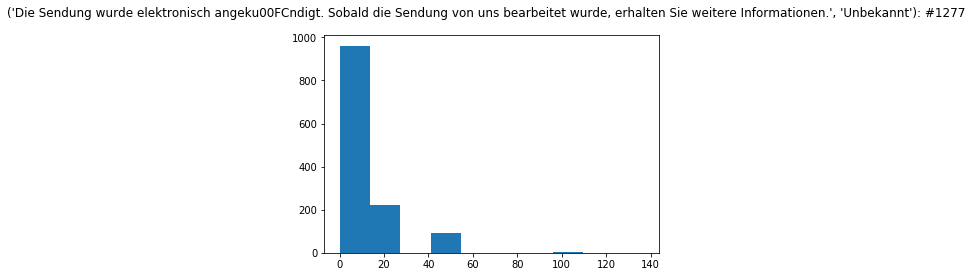

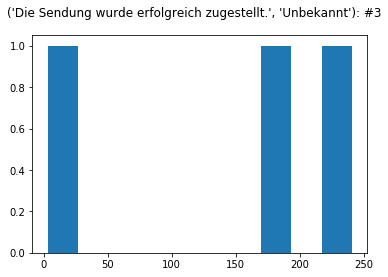

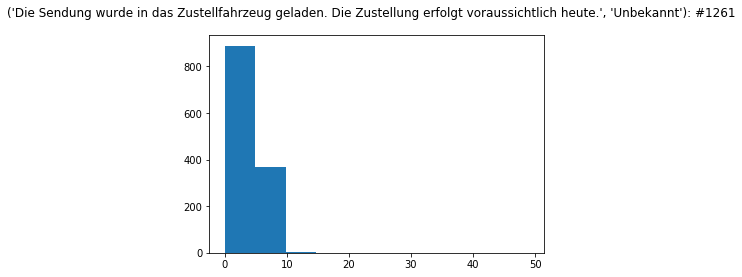

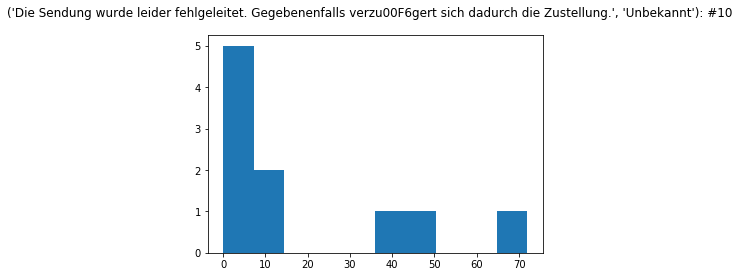

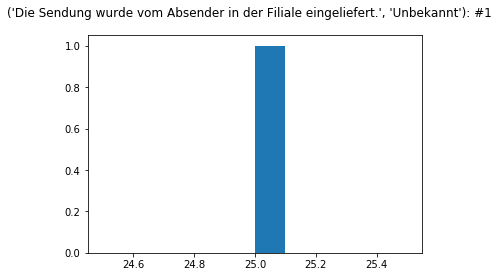

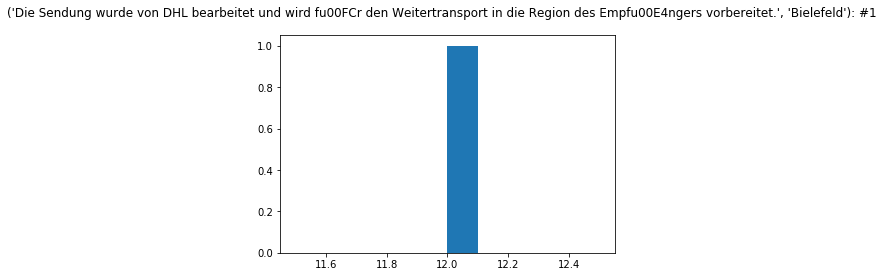

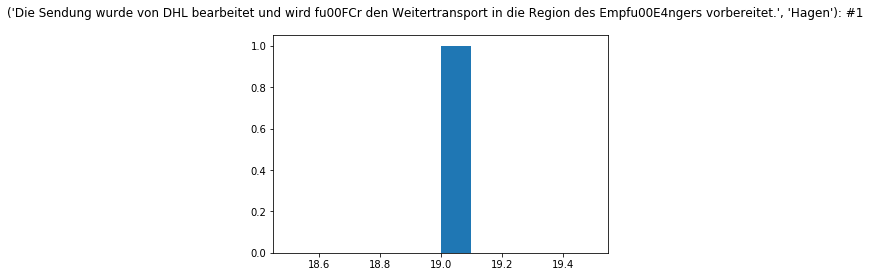

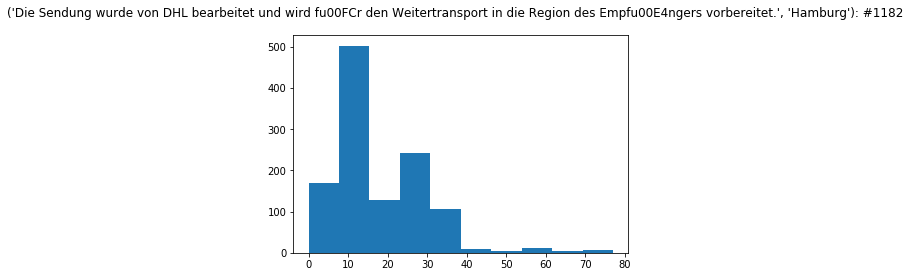

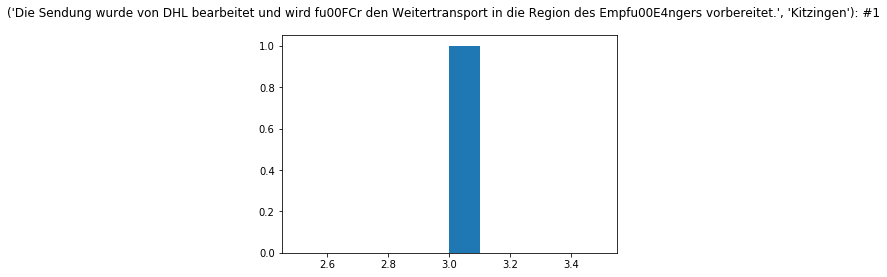

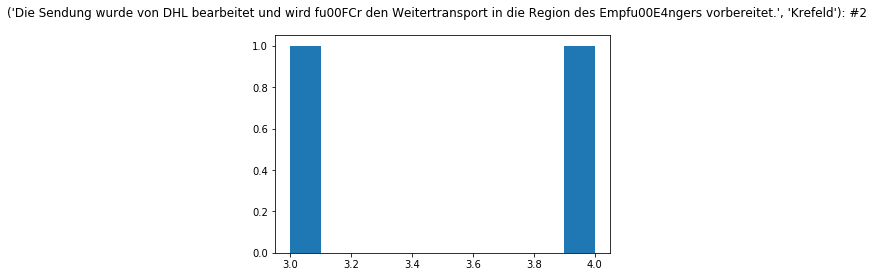

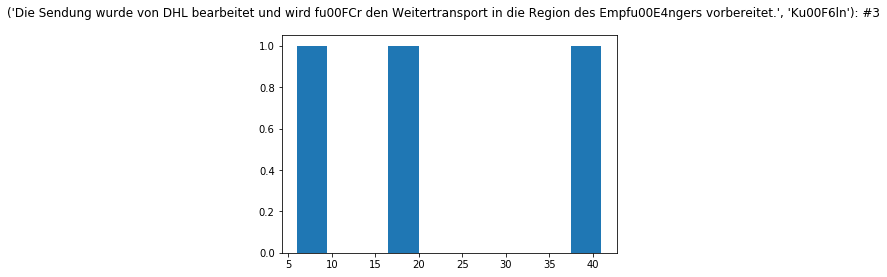

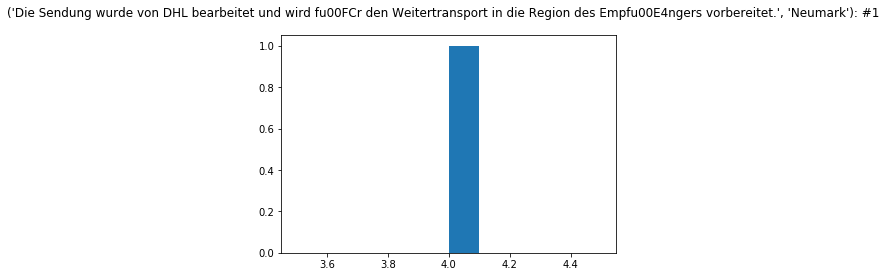

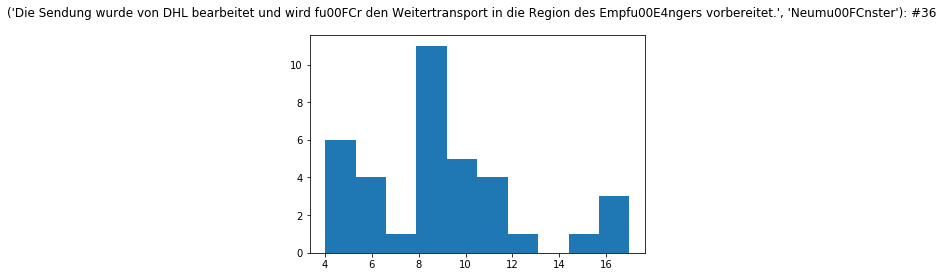

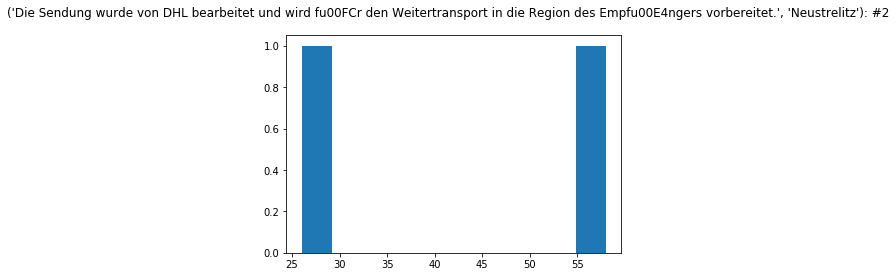

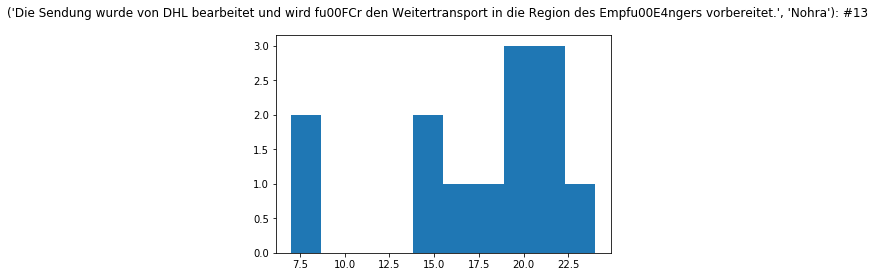

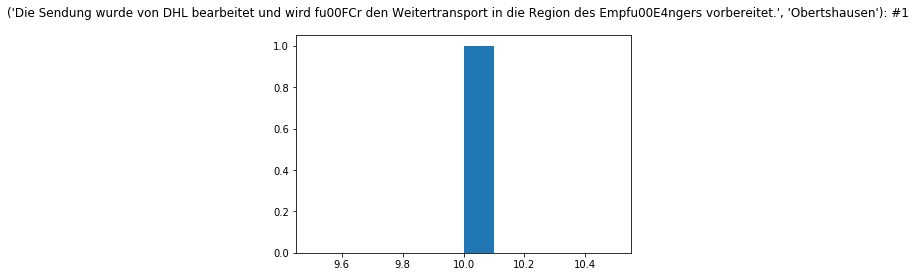

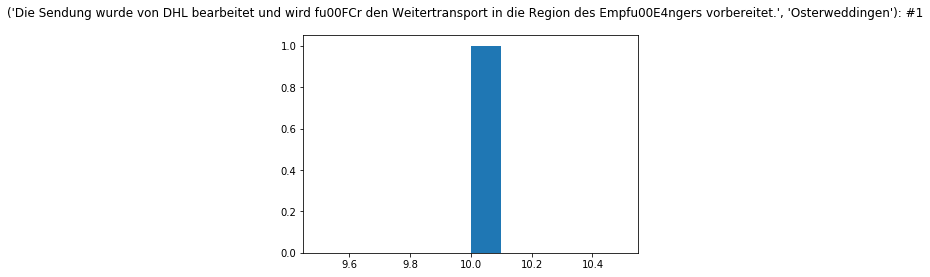

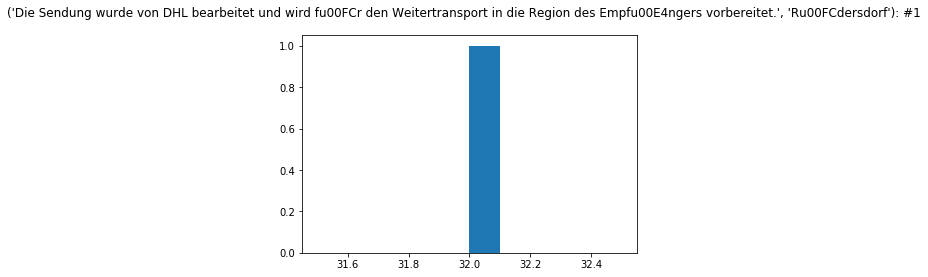

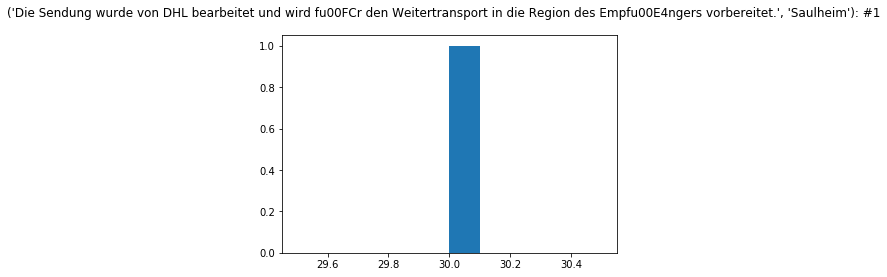

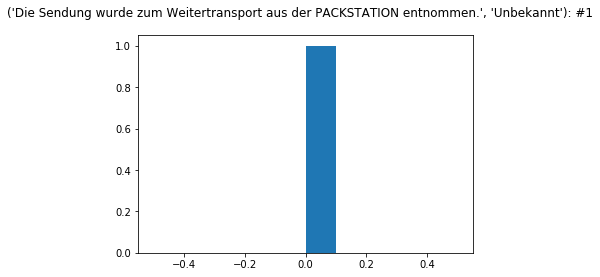

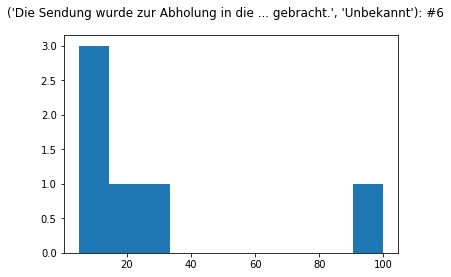

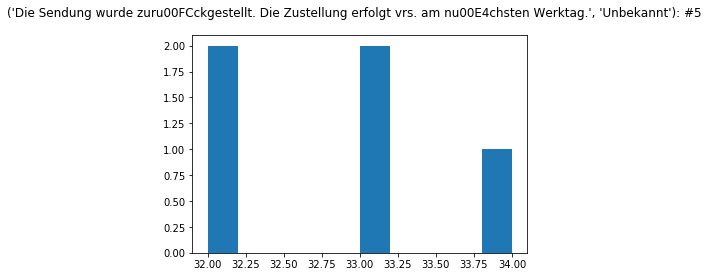

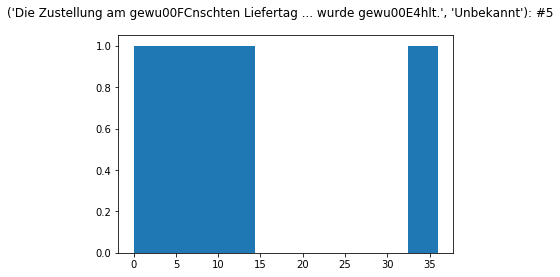

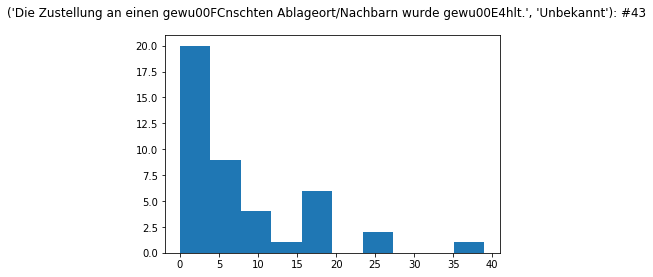

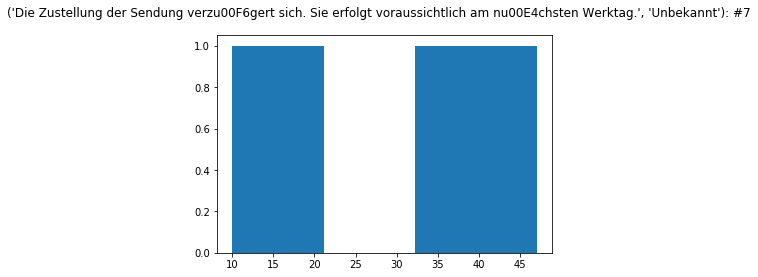

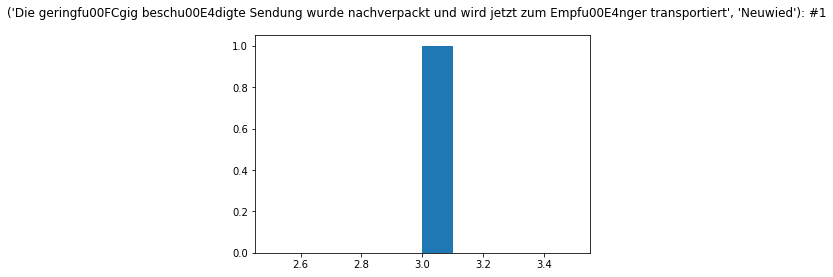

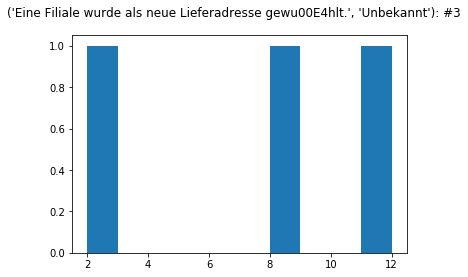

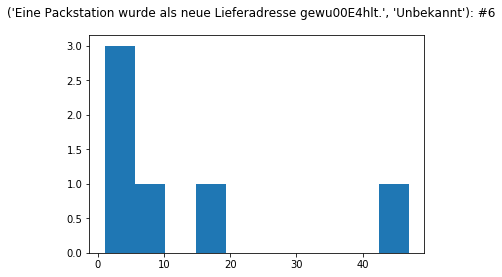

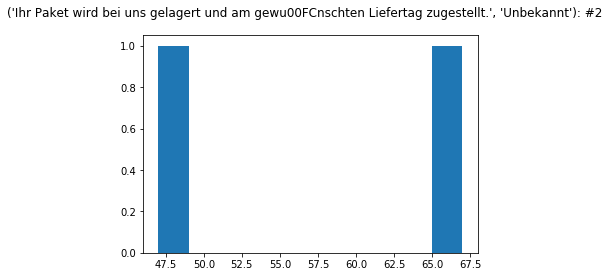

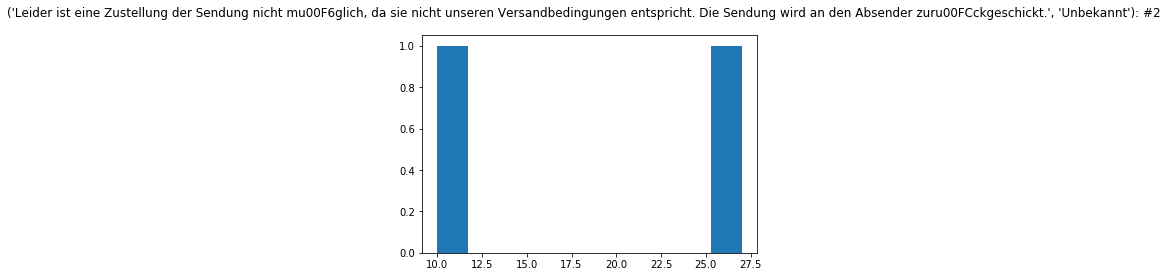

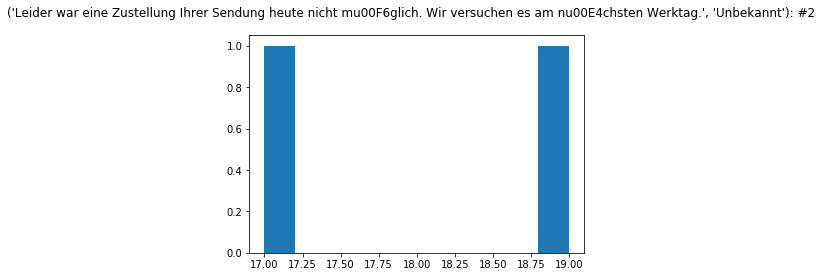

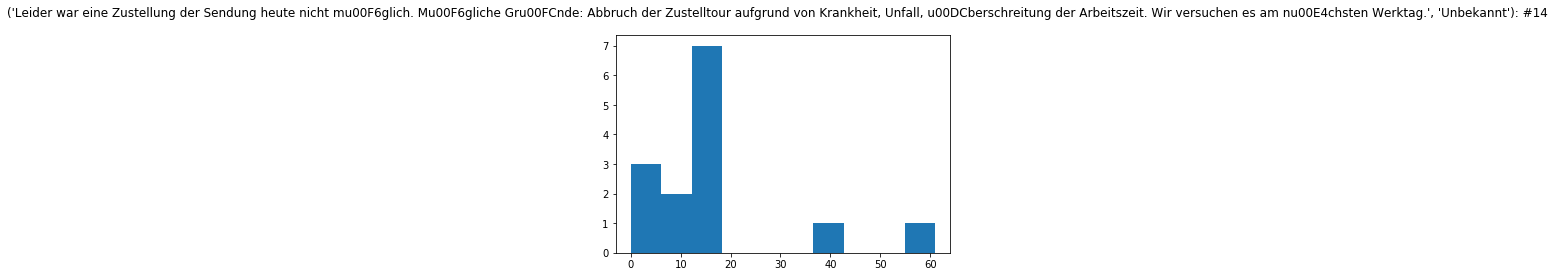

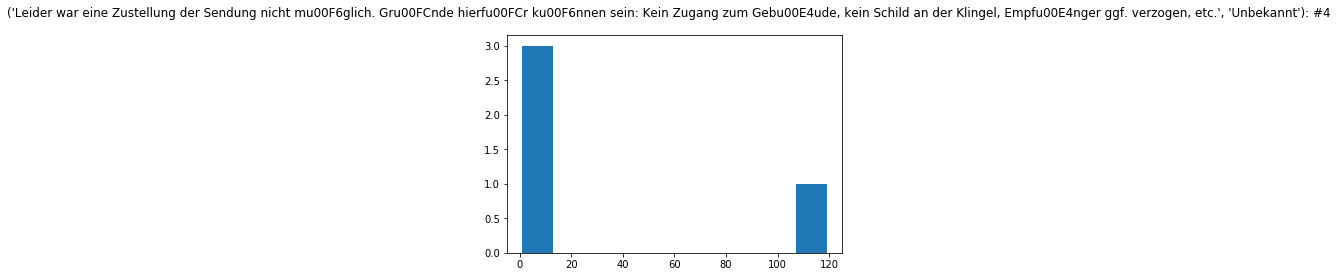

In [54]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


grouped = df_temp.groupby(["status", "ort"])

for name, group in grouped:
    fig = plt.figure()
    fig.suptitle(str(name) + ": #{}".format(len(group)))
    matplotlib.pyplot.hist(group.datum_diff_h)
    plt.show()
    
df.drop(columns=["datum_diff_h"], inplace=True)

In [55]:
df.head()

shipment_number                     datum  \
0  00340434188193339722 2019-11-29 15:27:00+00:00   
1  00340434188193339722 2019-11-30 14:04:00+00:00   
2  00340434188193339722 2019-12-02 21:11:00+00:00   
3  00340434188193339722 2019-12-03 08:33:00+00:00   
4  00340434188193339722 2019-12-03 11:28:00+00:00   

                                              status           ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...     Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...       Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...  Gu00FCnzburg   
3  Die Sendung wurde in das Zustellfahrzeug gelad...     Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.     Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next                datum_next      datum_diff  
0          Hamburg 2019-11-30 14:04:00+00:00 0 days 22:37:00  
1     Gu00FCnzburg 2019-12-02 21:11:00+00:00 2 days 07:07:00  
2        Unbekannt 2019-12-03 08:33:00+00:00 0 days 11:22:00  
3        Unbekannt 2019-12-03 11:28:00+00:00 0 days 02:55:00  
4  SuccessDelivery 2019-12-12 00:00:00+00:00 8 days 12:32:00

### Define the problem as a regression problem

In [209]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

This means now that we want to predict the time between two events. The column "datum_diff_h" tells us the time diff betwen the two events in hours

##### First we only use two features. So the question is, given status and ort of an event, can we predict, when the next event will happen?

In [210]:
df_temp = df[df["is_final_event"] == 0]
X = df_temp[["status", "ort"]]
y = df_temp["datum_diff_h"]

Notice that "status" and "ort" are categorical variables. We shoud encode them!

In [211]:
X["status"] = X["status"].astype('category')
X["status_code"] = X["status"].cat.codes
X["ort"] = X["ort"].astype('category')
X["ort_code"] = X["ort"].cat.codes

Create trainig and test set

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [213]:
X.head()

status           ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...     Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...       Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...  Gu00FCnzburg   
3  Die Sendung wurde in das Zustellfahrzeug gelad...     Unbekannt   
0  Die Sendung wurde elektronisch angeku00FCndigt...     Unbekannt   

   status_code  ort_code  
0           17       131  
1           22        56  
2            5        54  
3           19       131  
0           17       131

In [214]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
regr.fit(X_train[["status_code", "ort_code"]], y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

##### Coefficient of determination R^2 of the prediction with cross validation

In [215]:
cross_val_score(regr, X_train[["status_code", "ort_code"]], y_train, cv=10)

array([-0.06174573,  0.17954159,  0.20715369,  0.2332792 ,  0.10717616,
        0.1705746 ,  0.10628042,  0.10445674,  0.18470752,  0.18304758])

##### Feature Importance

In [216]:
print(regr.feature_importances_)

[0.96434195 0.03565805]


"status" played a bigger role in predictions comparing to "ort"

##### Fit the model and test it on the test set

In [217]:
model = regr.fit(X_train[["status_code", "ort_code"]], y_train)

In [218]:
y_pred = model.predict(X_test[["status_code", "ort_code"]])

##### Metrics

In [219]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 6.613192967363033
Mean Squared Error: 113.96658475178398
Root Mean Squared Error: 10.675513324978054


##### Distribution of errors

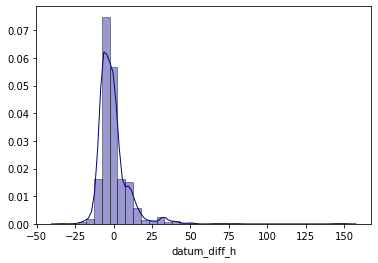

In [220]:
import seaborn as sns
sns.distplot(y_test-y_pred, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

### For which data point do I have a minimal error?

In [221]:
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)

In [222]:
prediction_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

In [223]:
prediction_df.head()

status         ort  status_code  \
0  Die Sendung ist in der Region des Empfu00E4nge...      Bremen            5   
1  Die Sendung ist in der Region des Empfu00E4nge...  Ku00F6ngen            5   
2  Die Sendung ist in der Region des Empfu00E4nge...     Neumark            5   
3  Die Sendung wurde in das Zustellfahrzeug gelad...   Unbekannt           19   
4  Die Sendung ist in der Region des Empfu00E4nge...    Radefeld            5   

   ort_code  datum_diff_h         0  
0        20           9.0  7.845586  
1        83          19.0  7.870920  
2        97           3.0  7.870920  
3       131           5.0  3.409157  
4       117           1.0  7.828749

In [224]:
prediction_df.columns = ['status', 'ort', 'status_code', 'ort_code', 'y', 'y_pred']

In [225]:
prediction_df.head()

status         ort  status_code  \
0  Die Sendung ist in der Region des Empfu00E4nge...      Bremen            5   
1  Die Sendung ist in der Region des Empfu00E4nge...  Ku00F6ngen            5   
2  Die Sendung ist in der Region des Empfu00E4nge...     Neumark            5   
3  Die Sendung wurde in das Zustellfahrzeug gelad...   Unbekannt           19   
4  Die Sendung ist in der Region des Empfu00E4nge...    Radefeld            5   

   ort_code     y    y_pred  
0        20   9.0  7.845586  
1        83  19.0  7.870920  
2        97   3.0  7.870920  
3       131   5.0  3.409157  
4       117   1.0  7.828749

In [226]:
prediction_df["diff"] = abs(prediction_df["y"] - prediction_df["y_pred"])

In [227]:
prediction_df.head()

status         ort  status_code  \
0  Die Sendung ist in der Region des Empfu00E4nge...      Bremen            5   
1  Die Sendung ist in der Region des Empfu00E4nge...  Ku00F6ngen            5   
2  Die Sendung ist in der Region des Empfu00E4nge...     Neumark            5   
3  Die Sendung wurde in das Zustellfahrzeug gelad...   Unbekannt           19   
4  Die Sendung ist in der Region des Empfu00E4nge...    Radefeld            5   

   ort_code     y    y_pred       diff  
0        20   9.0  7.845586   1.154414  
1        83  19.0  7.870920  11.129080  
2        97   3.0  7.870920   4.870920  
3       131   5.0  3.409157   1.590843  
4       117   1.0  7.828749   6.828749

In [228]:
prediction_df[prediction_df["diff"] > 70].values

array([['Die Sendung wird zur Abholung in die ... gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden.',
        'Unbekannt', 15, 131, 165.0, 20.02534772554936,
        144.97465227445065],
       ['Die Sendung wurde erfolgreich zugestellt.', 'Unbekannt', 18,
        131, 192.0, 112.0101734486494, 79.9898265513506],
       ['Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit.',
        'Unbekannt', 10, 131, 97.0, 24.32077177647672, 72.67922822352328],
       ['Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit.',
        'Unbekannt', 10, 131, 175.0, 24.32077177647672,
        150.67922822352327]], dtype=object)